In [93]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# Training data preparation 

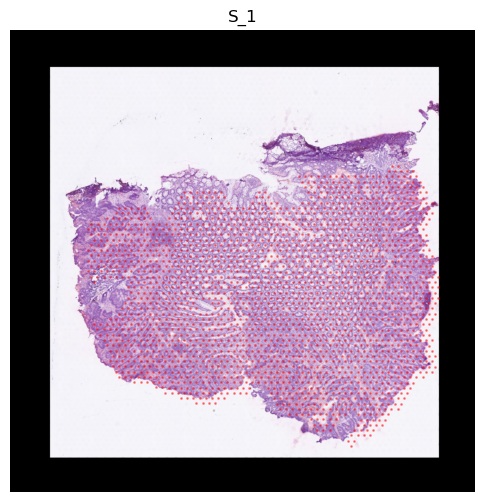

In [2]:
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [3]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/version-7/no_gu_clip4_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './dataset/version-7/no_gu_clip4_processed_train_spots.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## log 2

In [94]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
#with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:

with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)
# 原始 abundance | 排名 (ordinal)
# 最大值 | 最大 rank（數字 最大）
# 最小值 | 1

# 用 "rank_" + 原本欄位名稱
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# 再和原資料合併
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)
# -----------------------------------------------------
# Step 4: 顯示排名後的統計描述
# -----------------------------------------------------
print("\n🏁 Ranking done! 每個 cell type 的排名描述:")
print(ranked_df[[col for col in ranked_df.columns if col.startswith("rank_C")]].describe())

# ranked_df 現在就可以用來做 Spearman-based 模型訓練 🎯


✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6

🏁 Ranking done! 每個 cell type 的排名描述:
           rank_C1      rank_C2      rank_C3      rank_C4      rank_C5  \
count  8348.000000  8348.000000  8348.000000  8348.000000  8348.000000   
mean     26.067920    27.408960    26.489938    17.432199    25.852899   
std       7.832288     3.594983     5.965318    12.165656    11.023578   
min       7.000000    15.000000    10.000000     1.000000     1.000000   
25%      19.000000    24.000000    21.000000     7.000000    18.000000   
50%      27.000000    28.000000    26.000000    14.000000    32.000000   
75%      34.000000    31.000000    33.000000    32.000000    34.000000   
max      35.000000    35.000000    35.000000    35.000000    35.000000   

           rank_C6      rank_C7      rank_C8      rank_C9     rank_C10  ...  \
count  8348.000000  8348.000000  8348.000000  8348.000000  8348.000000  ...   
mean     15.268088    20.200168    1

In [95]:
all_train_spots_df

x     y        C1        C2        C3        C4        C5        C6  \
0     1499  1237  0.014401  0.057499  0.022033  0.001704  0.533992  1.511707   
1      407  1442  0.116196  0.197176  0.110600  0.042614  5.587681  0.006885   
2     1433  1488  0.133284  0.035880  0.061352  0.003073  1.104479  0.009174   
3     1670  1122  0.087715  0.235223  0.090382  0.013902  8.760482  0.140912   
4      526  1053  0.128468  0.066399  0.098982  0.047022  3.425771  0.001009   
...    ...   ...       ...       ...       ...       ...       ...       ...   
8343  1143   812  0.008615  0.052352  0.009905  0.003060  5.230128  0.000176   
8344  1207   745  0.034781  0.028511  0.031475  0.001812  1.121948  0.000052   
8345   873   923  0.000515  0.011848  0.001639  0.000039  0.104526  0.000024   
8346   924  1280  0.009845  0.076963  0.013963  0.001142  5.819259  0.000598   
8347  1156   834  0.329317  0.067147  0.057116  0.002136  4.675503  0.000263   

            C7        C8  ...       C27       C28       C29       C30  \
0     0.015313  0.020029  ...  2.068237  0.121361  0.007344  0.000017   
1     0.096346  0.001711  ...  0.014442  0.000238  0.024071  0.000023   
2     0.009175  0.000114  ...  0.149792  0.001401  0.000699  0.000009   
3     0.188859  0.010154  ...  0.142549  0.002036  0.047165  0.000022   
4     0.026881  0.000468  ...  0.005920  0.000048  0.006359  0.000585   
...        ...       ...  ...       ...       ...       ...       ...   
8343  0.040653  0.000188  ...  0.006530  0.000047  0.011358  0.000007   
8344  0.008572  0.001044  ...  0.000060  0.000802  0.020970  0.000100   
8345  0.001327  0.000014  ...  0.000041  0.000010  0.000049  0.000019   
8346  0.073316  0.000391  ...  0.032145  0.000371  0.019168  0.000122   
8347  0.050364  0.000716  ...  0.004805  0.000107  0.017325  0.000019   

           C31       C32       C33       C34       C35  slide_name  
0     0.036891  0.035934  0.118937  0.001472  0.050057         S_1  
1     0.217589  0.100662  0.004027  0.004122  0.049491         S_1  
2     0.024491  0.018810  0.004171  0.000425  0.015348         S_1  
3     0.180372  0.202981  0.003709  0.001845  0.116022         S_1  
4     0.052661  0.032168  0.000107  0.000107  0.013103         S_1  
...        ...       ...       ...       ...       ...         ...  
8343  0.037057  0.018493  0.000290  0.000296  0.010812         S_6  
8344  0.020329  0.011358  0.000215  0.000113  0.004115         S_6  
8345  0.007001  0.002478  0.041246  0.000018  0.000621         S_6  
8346  0.068377  0.031485  0.000532  0.000437  0.018696         S_6  
8347  0.048596  0.023379  0.044694  0.000392  0.015084         S_6  

[8348 rows x 38 columns]

In [97]:
# 1) 计算每个 slide 的最小表达（跨所有 spots、所有 cell types）
slide_min = (
    all_train_spots_df
    .groupby('slide_name')[cell_cols]    # cell_cols = ['C1','C2',…,'C35']
    .min()                               # 得到 DataFrame: index=slide_name, columns=cell_cols
    .min(axis=1)                         # 再对 cell_cols axis=1 取最小 -> Series, index=slide_name
)
# 2) 把这个 slide 最小值映射回每一行
min_expr = (
    all_train_spots_df['slide_name']
    .map(slide_min)                      # Series 长度 N
    .values
    .reshape(-1, 1)                      # 变成 (N,1)
)
min_expr

array([[1.19531128e-09],
       [1.19531128e-09],
       [1.19531128e-09],
       ...,
       [9.97579326e-09],
       [9.97579326e-09],
       [9.97579326e-09]])

In [109]:
# 1) 计算每个 slide 的最小表达（跨所有 spots、所有 cell types）
slide_min = (
    all_train_spots_df
    .groupby('slide_name')[cell_cols]    # cell_cols = ['C1','C2',…,'C35']
    .min()                               # 得到 DataFrame: index=slide_name, columns=cell_cols
    .min(axis=1)                         # 再对 cell_cols axis=1 取最小 -> Series, index=slide_name
)

# 2) 把这个 slide 最小值映射回每一行
min_expr = (
    all_train_spots_df['slide_name']
    .map(slide_min)                      # Series 长度 N
    .values
    .reshape(-1, 1)                      # 变成 (N,1)
)

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)

# 之后再做 scaled、log2_coeff、wranks 就和之前一样
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)
wranks     = ranks*log2_coeff
# 直接替换 ranked_df 中的 rank 列
for i, col in enumerate(rank_cols):
    ranked_df[col] = wranks[:, i]

# 这样，ranked_df 里原先的 rank_* 就被新的 wrank_* 覆盖了
print(ranked_df[rank_cols].head())




      rank_C1     rank_C2     rank_C3     rank_C4      rank_C5     rank_C6  \
0  601.341138  703.291918  631.806281  459.791231   884.161668  975.696766   
1  758.153826  800.749606  754.238101  680.554513  1097.081197  550.259231   
2  769.093674  667.668121  708.263930  497.020407   947.613519  569.861523   
3  735.978799  815.220416  738.325515  598.851455  1140.478874  773.553570   
4  766.151916  714.346655  745.468859  687.984299  1050.822676  427.952915   

      rank_C7     rank_C8     rank_C9    rank_C10  ...    rank_C26  \
0  605.694432  624.911823  949.434299  983.095953  ...  427.990258   
1  743.344123  460.076013  637.262168  888.732460  ...  405.726141   
2  569.866347  307.729307  788.272834  713.358533  ...  298.942964   
3  797.235041  576.874531  842.094629  709.930289  ...  468.639680   
4  646.314331  383.288958  677.630288  441.840715  ...  284.803854   

      rank_C27    rank_C28    rank_C29    rank_C30    rank_C31    rank_C32  \
0  1004.152675  761.613449  554.

In [110]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "dataset/realign"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "log2_nor_slide_min_spots_time_rank.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：dataset/realign/log2_nor_slide_min_spots_time_rank.h5


In [ ]:
import numpy as np
import pandas as pd

# 假设 all_train_spots_df, ranked_df 已经存在

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)

# 计算加权系数
min_expr   = expr.min(axis=1, keepdims=True)
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)                    # (N,35)

# 乘上原始 rank 得到 wranks
wranks = log2_coeff                     # (N,35)

# 直接替换 ranked_df 中的 rank 列
for i, col in enumerate(rank_cols):
    ranked_df[col] = wranks[:, i]

# 这样，ranked_df 里原先的 rank_* 就被新的 wrank_* 覆盖了
print(ranked_df[rank_cols].head())


     rank_C1    rank_C2    rank_C3    rank_C4    rank_C5    rank_C6  \
0  10.705398  12.702791  11.318897   7.625883  15.917996  17.419285   
1  13.307512  14.070438  13.236315  11.860359  18.895135   9.230524   
2  14.858261  12.964997  13.738951   9.419677  17.909055  10.997495   
3  12.975031  14.398167  13.018248  10.317543  19.617078  13.658933   
4  12.386135  11.433950  12.009961  10.936140  17.123081   5.393708   

     rank_C7    rank_C8    rank_C9   rank_C10  ...  rank_C26   rank_C27  \
0  10.794000  11.181376  16.996032  17.537501  ...  6.871065  17.871508   
1  13.037257   7.222302  11.016971  15.584535  ...  5.915564  10.299275   
2  10.997596   4.667938  15.201920  13.834495  ...  4.415690  15.026726   
3  14.081453   9.864314  14.864968  12.490619  ...  7.494189  13.675598   
4  10.129398   4.284452  10.738018   5.726693  ...  1.582818   7.946503   

    rank_C28   rank_C29  rank_C30   rank_C31   rank_C32   rank_C33  rank_C34  \
0  13.780485   9.733983  1.000000  12.0625

In [ ]:
import numpy as np
import pandas as pd

import pandas as pd

def add_topk_columns(df: pd.DataFrame,
                     rank_cols: list[str],
                     K: int):
    """
    在 df 里新增 top1, top2, …, topK 这 K 列，
    分别存放每个 spot 在 rank_cols 中表达量（rank 值）最大的 K 个 cell type 名称。

    Args:
        df: 原始 DataFrame，至少包含 rank_cols 这些列。
        rank_cols: ['rank_C1','rank_C2',…,'rank_C35']
        K: 取前 K 名。
    Returns:
        新的 DataFrame，原表 + top1…topK 列。
    """
    # 对每一行，挑出前 K 名列名
    def _topk(row):
        # row 是一个 pd.Series，index 是 rank_cols
        # nlargest 会返回一个 Series，index 就是对应的列名（cell type）
        topk_idx = row.nlargest(K).index.tolist()
        # 如果某些行不足 K 个（理论上不会），可以 pad None
        if len(topk_idx) < K:
            topk_idx += [None] * (K - len(topk_idx))
        return pd.Series(topk_idx, index=[f"top{i+1}" for i in range(K)])

    # 逐行 apply
    topk_df = df[rank_cols].apply(_topk, axis=1)
    # 合并回去
    return pd.concat([df.reset_index(drop=True), topk_df], axis=1)



def count_groups_by_topk(ranked_df: pd.DataFrame, rank_cols: list[str], K: int) -> int:
    """
    按每个 spot 的前 K 名 cell type 身份来分组，返回有多少个不同组合。
    
    Args:
        ranked_df: 已有 rank_C1...rank_C35 等列的 DataFrame。
        rank_cols: ['rank_C1', 'rank_C2', ..., 'rank_C35']
        K: 取排名最高的 K 个 cell type。
    Returns:
        不同组合数。
    """
    # 1) 先找出前 K 名对应的 cell type 名称
    #    这里我们假设 rank 越大表示表达越高
    def topk_cell_types(row):
        # row[rank_cols] 是一个长度 35 的 Series
        # sort_values 降序：大的在前面
        topk = row[rank_cols].sort_values(ascending=False).index[:K]
        return list(topk)
    
    # 对所有行计算一次，得到一个 (N_spots, K) 的列表
    topk_list = ranked_df.apply(topk_cell_types, axis=1, result_type="expand")
    topk_list.columns = [f"top{idx+1}" for idx in range(K)]
    
    # 2) 拼回原表（也可以只保留这 K 列）
    tmp = pd.concat([ranked_df.reset_index(drop=True), topk_list], axis=1)
    
    # 3) 去重后行数就是分组数
    n_groups = tmp[[f"top{i+1}" for i in range(K)]].drop_duplicates().shape[0]
    return n_groups

# 假设你的 ranked_df 已经有了 'rank_C1'…'rank_C35'
rank_cols = [f"rank_C{i}" for i in range(1, 36)]

# 取 Top-3
df3 = add_topk_columns(ranked_df, rank_cols, K=3)

# 看一下前几行
print(df3[['top1','top2','top3']].head())

# 各种统计：

# 1) 统计单个位置上 top1, top2, top3 的分布
print("Top1 counts:\n", df3['top1'].value_counts(), "\n")
print("Top2 counts:\n", df3['top2'].value_counts(), "\n")
print("Top3 counts:\n", df3['top3'].value_counts(), "\n")

# 2) 如果想看 “(top1,top2,top3)” 这个组合出现了多少种，以及各自频次：
combo_counts = df3.groupby(['top1','top2','top3']).size().sort_values(ascending=False)
print("Top-3 combinations and their counts:\n", combo_counts.head(10))


# —— 举例：看前 1 到前 10 名时，各能分多少组 ——
rank_cols = [f"rank_C{i}" for i in range(1, 36)]
for K in [1]:
    n = count_groups_by_topk(ranked_df, rank_cols, K)
    print(f"Top {K}: {n} groups")


       top1
0  rank_C16
1   rank_C5
2   rank_C5
3   rank_C5
4   rank_C5
Top1 counts:
 top1
rank_C16    2066
rank_C5     1989
rank_C1     1979
rank_C17     527
rank_C25     449
rank_C9      231
rank_C11     203
rank_C3      193
rank_C30     138
rank_C4      135
rank_C20      67
rank_C27      66
rank_C24      55
rank_C26      54
rank_C6       48
rank_C14      34
rank_C19      27
rank_C10      13
rank_C8       11
rank_C33      10
rank_C23       9
rank_C21       8
rank_C31       7
rank_C34       6
rank_C29       6
rank_C2        5
rank_C18       3
rank_C7        3
rank_C22       3
rank_C32       1
rank_C13       1
rank_C15       1
Name: count, dtype: int64 

Top-3 combinations and their counts:
 top1
rank_C16    2066
rank_C5     1989
rank_C1     1979
rank_C17     527
rank_C25     449
rank_C9      231
rank_C11     203
rank_C3      193
rank_C30     138
rank_C4      135
dtype: int64
Top 1: 32 groups


In [89]:
ranked_df

x     y slide_name    rank_C1    rank_C2    rank_C3    rank_C4  \
0     1499  1237        S_1  10.705398  12.702791  11.318897   7.625883   
1      407  1442        S_1  13.307512  14.070438  13.236315  11.860359   
2     1433  1488        S_1  14.858261  12.964997  13.738951   9.419677   
3     1670  1122        S_1  12.975031  14.398167  13.018248  10.317543   
4      526  1053        S_1  12.386135  11.433950  12.009961  10.936140   
...    ...   ...        ...        ...        ...        ...        ...   
8343  1143   812        S_6  12.316015  14.919392  12.517419  10.822903   
8344  1207   745        S_6  15.700636  15.413834  15.556551  11.437665   
8345   873   923        S_6  12.849424  17.373674  14.519968   9.141792   
8346   924  1280        S_6  11.382078  14.348739  11.886208   8.274593   
8347  1156   834        S_6  17.522387  15.228299  14.994886  10.253957   

        rank_C5    rank_C6    rank_C7  ...   rank_C27   rank_C28   rank_C29  \
0     15.917996  17.419285  10.794000  ...  17.871508  13.780485   9.733983   
1     18.895135   9.230524  13.037257  ...  10.299275   4.373842  11.036301   
2     17.909055  10.997495  10.997596  ...  15.026726   8.286475   7.282567   
3     19.617078  13.658933  14.081453  ...  13.675598   7.545891  12.079928   
4     17.123081   5.393708  10.129398  ...   7.946503   1.000000   8.049660   
...         ...        ...        ...  ...        ...        ...        ...   
8343  21.561843   6.703750  14.554518  ...  11.916293   4.789263  12.714849   
8344  20.712189   6.302491  13.679951  ...   6.513024  10.261372  14.970648   
8345  20.514836   8.398584  14.215625  ...   9.198125   7.096189   9.459247   
8346  20.589266   7.340700  14.278697  ...  13.089186   6.652231  12.343271   
8347  21.349961   7.229598  14.813384  ...  11.423538   5.934488  13.273844   

      rank_C30   rank_C31   rank_C32   rank_C33  rank_C34   rank_C35  top_cell  
0     1.000000  12.062503  12.024591  13.751379  7.414866  12.502811  rank_C16  
1     1.000000  14.212565  13.100470   8.456942  8.490562  12.076207   rank_C5  
2     1.000000  12.414079  12.033351   9.860208  6.564170  11.739860   rank_C5  
3     1.000000  14.015112  14.185486   8.411159  7.403653  13.378544   rank_C5  
4     4.608536  11.099534  10.388435   2.162186  2.150680   9.092672   rank_C5  
...        ...        ...        ...        ...       ...        ...       ...  
8343  2.070102  14.420891  13.418111   7.422235  7.451402  12.643824   rank_C5  
8344  7.263934  14.925887  14.086072   8.364306  7.439534  12.621380   rank_C5  
8345  8.077182  16.614686  15.116452  19.173290  7.971306  13.119823  rank_C17  
8346  5.047195  14.178094  13.059233   7.172107  6.887956  12.307296   rank_C5  
8347  3.413873  14.761832  13.706183  14.641053  7.807977  13.074018   rank_C5  

[8348 rows x 39 columns]

In [ ]:
# —— 举例：看前 1 到前 10 名时，各能分多少组 ——
rank_cols = [f"rank_C{i}" for i in range(1, 36)]
for K in [3]:
    n = count_groups_by_topk( oversampled_dict['S_3'], rank_cols, K)
    print(f"Top {K}: {n} groups")
    

Top 3: 1194 groups


In [63]:
combo_counts = df3.groupby(['top1','top2','top3']).size().sort_values(ascending=False)
combo_counts

top1      top2      top3    
rank_C1   rank_C3   rank_C4     1281
rank_C16  rank_C9   rank_C27     376
          rank_C27  rank_C9      268
          rank_C15  rank_C9      225
          rank_C9   rank_C15     184
                                ... 
          rank_C5   rank_C21       1
rank_C25  rank_C30  rank_C9        1
rank_C16  rank_C5   rank_C20       1
rank_C25  rank_C33  rank_C17       1
rank_C23  rank_C16  rank_C27       1
Length: 1313, dtype: int64

In [48]:
for slide in ranked_df['slide_name'].unique():
    df_sub = ranked_df[ranked_df['slide_name'] != slide]
    top1_count = df_sub['top_cell'].nunique()
    print(f"Drop {slide}: Top-1 distinct = {top1_count}")

df_sub

Drop S_1: Top-1 distinct = 31
Drop S_2: Top-1 distinct = 30
Drop S_3: Top-1 distinct = 32
Drop S_4: Top-1 distinct = 32
Drop S_5: Top-1 distinct = 30
Drop S_6: Top-1 distinct = 32


x     y slide_name    rank_C1    rank_C2    rank_C3    rank_C4  \
0     1499  1237        S_1  10.705398  12.702791  11.318897   7.625883   
1      407  1442        S_1  13.307512  14.070438  13.236315  11.860359   
2     1433  1488        S_1  14.858261  12.964997  13.738951   9.419677   
3     1670  1122        S_1  12.975031  14.398167  13.018248  10.317543   
4      526  1053        S_1  12.386135  11.433950  12.009961  10.936140   
...    ...   ...        ...        ...        ...        ...        ...   
8015   945   536        S_5  13.647408  11.225345  12.202151  12.391235   
8016   932  1268        S_5  12.475742  14.741899  11.856897   1.690588   
8017   715   625        S_5   9.997283  12.682135  10.466570   1.000000   
8018   996   669        S_5  14.671658  12.357964  12.998292   8.746056   
8019  1161   825        S_5   8.989085  11.606874   9.423402   2.283726   

        rank_C5    rank_C6    rank_C7  ...   rank_C27   rank_C28   rank_C29  \
0     15.917996  17.419285  10.794000  ...  17.871508  13.780485   9.733983   
1     18.895135   9.230524  13.037257  ...  10.299275   4.373842  11.036301   
2     17.909055  10.997495  10.997596  ...  15.026726   8.286475   7.282567   
3     19.617078  13.658933  14.081453  ...  13.675598   7.545891  12.079928   
4     17.123081   5.393708  10.129398  ...   7.946503   1.000000   8.049660   
...         ...        ...        ...  ...        ...        ...        ...   
8015  15.919421  12.010688   9.780201  ...  15.518106   8.541406   7.942192   
8016   6.865520   1.965803  10.832873  ...   2.760432   8.871919   6.371644   
8017  12.848223  13.134748   9.252042  ...  12.945498  12.161244  10.658149   
8018  12.068275  10.408939   8.920751  ...  11.688373   2.150978   2.208105   
8019  12.024951   7.494906   8.298580  ...   9.856962   4.020617   4.836999   

       rank_C30   rank_C31   rank_C32   rank_C33   rank_C34   rank_C35  \
0      1.000000  12.062503  12.024591  13.751379   7.414866  12.502811   
1      1.000000  14.212565  13.100470   8.456942   8.490562  12.076207   
2      1.000000  12.414079  12.033351   9.860208   6.564170  11.739860   
3      1.000000  14.015112  14.185486   8.411159   7.403653  13.378544   
4      4.608536  11.099534  10.388435   2.162186   2.150680   9.092672   
...         ...        ...        ...        ...        ...        ...   
8015   1.000000  10.631903  10.480959   1.453046   3.600354  10.357921   
8016  15.560025  13.439177  13.085384   7.770361   8.763303  11.328904   
8017  11.594529  11.808038  11.594392   6.104523  12.440462  10.150236   
8018   1.651308  11.553563  11.261448   6.919823  11.433622   8.861861   
8019   7.784009  10.533382  10.430252   6.398569   9.019265   8.600210   

      top_cell  
0     rank_C16  
1      rank_C5  
2      rank_C5  
3      rank_C5  
4      rank_C5  
...        ...  
8015   rank_C9  
8016  rank_C25  
8017  rank_C25  
8018  rank_C16  
8019  rank_C16  

[8020 rows x 39 columns]

In [90]:
import pandas as pd


import pandas as pd
import math

def make_capped_oversampled_dict_by_topk(
    df: pd.DataFrame,
    rank_cols: list[str],
    K: int = 1,
    N_max: int = 100000,
    fill_to_n_max: bool = False,
    slide_col: str = "slide_name",
    random_state: int = 42
) -> tuple[dict[str, pd.DataFrame], pd.DataFrame]:
    """
    LOOG 风格的 capped over-/under-sampling：
      - 分组：每个 spot 的 Top-K 组合
      - 目标：每折（drop 一个 slide）后，总行数不超过 N_max
        * 如果可能，全组采样到 floor(N_max / n_groups) 后正好凑满或低于 N_max
        * 如果 floor(N_max / n_groups) > max_group_size:
            - 若 fill_to_n_max=True，则采样到 ceil(N_max / n_groups)，再裁剪到 N_max
            - 否则只采样到 max_group_size，总行数 < N_max
    Returns:
      oversampled_dict: {drop 那个 slide: 过采样 DataFrame}
      summary_df: 每折原始/过采样前后行数
    """
    # 1) 给每个 spot 生成 top1…topK 列
    def _topk(row):
        topk = row.nlargest(K).index.tolist()
        if len(topk) < K:
            topk += [None] * (K - len(topk))
        return pd.Series(topk, index=[f"top{i+1}" for i in range(K)])
    
    dfk = pd.concat([
        df.reset_index(drop=True),
        df[rank_cols].apply(_topk, axis=1)
    ], axis=1)
    label_cols = [f"top{i+1}" for i in range(K)]
    
    oversampled_dict = {}
    summary = {}
    
    for slide in dfk[slide_col].unique():
        # 留出这一张 slide
        train_sub = dfk[dfk[slide_col] != slide].reset_index(drop=True)
        orig_n = len(train_sub)
        
        # 统计每个组合的大小
        grp_sizes = train_sub.groupby(label_cols).size()
        n_groups = len(grp_sizes)
        max_size = int(grp_sizes.max())
        
        # 理想情况下每组目标大小：
        base_target = N_max // n_groups
        
        # 如果 base_target > max_size，需要根据 fill_to_n_max 决定
        if base_target <= max_size:
            target_size = base_target
            do_trim = False
        else:
            if fill_to_n_max:
                # 往上凑：用 ceil
                target_size = math.ceil(N_max / n_groups)
                do_trim = True
            else:
                # 不再填：只到已有最大组大小
                target_size = max_size
                do_trim = False
        
        parts = []
        for combo, cnt in grp_sizes.items():
            # scalar -> tuple
            combo = (combo,) if K == 1 else combo
            
            # 按 combo 筛行
            mask = pd.Series(True, index=train_sub.index)
            for col, val in zip(label_cols, combo):
                mask &= (train_sub[col] == val)
            df_grp = train_sub[mask]
            
            # 原样保留
            parts.append(df_grp)
            
            # 过/欠采样
            if cnt < target_size:
                # oversample
                extra = df_grp.sample(
                    n = target_size - cnt,
                    replace = True,
                    random_state = random_state
                )
                parts.append(extra)
            elif cnt > target_size:
                # under-sample
                df_grp = df_grp.sample(
                    n = target_size,
                    replace = False,
                    random_state = random_state
                )
                # 用裁剪后的 df_grp 替换原部分
                parts[-1] = df_grp
        
        df_over = pd.concat(parts, ignore_index=True)
        
        # 如果需要精确到 N_max，则 trim
        if do_trim and len(df_over) > N_max:
            df_over = df_over.sample(n=N_max, random_state=random_state).reset_index(drop=True)
        
        oversampled_dict[slide] = df_over
        summary[slide] = {
            "original_count": orig_n,
            "oversampled_count": len(df_over)
        }
        print(f"▶️ Drop {slide}: original={orig_n}, oversampled={len(df_over)} "
              f"(target/group={target_size}, groups={n_groups})")
    
    summary_df = pd.DataFrame.from_dict(summary, orient="index")
    summary_df.index.name = slide_col
    return oversampled_dict, summary_df



rank_cols = [f"rank_C{i}" for i in range(1,36)]

oversampled_dict, summary_df = make_capped_oversampled_dict_by_topk(
    df = ranked_df,
    rank_cols = rank_cols,
    K =1,                   # <- 这里指定 Top-3
    slide_col = "slide_name",
    random_state = 42
)

print("\n=== 过采样后大小汇总 ===")
print(summary_df)

# 查看去掉 'S_4' 后过采样的分布
df_over_S4 = oversampled_dict['S_4']
print(df_over_S4[['top1' ]].value_counts())



▶️ Drop S_1: original=6151, oversampled=60388 (target/group=1948, groups=31)
▶️ Drop S_2: original=6079, oversampled=58170 (target/group=1939, groups=30)
▶️ Drop S_3: original=7658, oversampled=65088 (target/group=2034, groups=32)
▶️ Drop S_4: original=7161, oversampled=62528 (target/group=1954, groups=32)
▶️ Drop S_5: original=6671, oversampled=59670 (target/group=1989, groups=30)
▶️ Drop S_6: original=8020, oversampled=66112 (target/group=2066, groups=32)

=== 过采样后大小汇总 ===
            original_count  oversampled_count
slide_name                                   
S_1                   6151              60388
S_2                   6079              58170
S_3                   7658              65088
S_4                   7161              62528
S_5                   6671              59670
S_6                   8020              66112
top1    
rank_C1     1954
rank_C10    1954
rank_C8     1954
rank_C7     1954
rank_C6     1954
rank_C5     1954
rank_C4     1954
rank_C34    1954
rank_C3

In [85]:
rank_cols

['rank_C1',
 'rank_C2',
 'rank_C3',
 'rank_C4',
 'rank_C5',
 'rank_C6',
 'rank_C7',
 'rank_C8',
 'rank_C9',
 'rank_C10',
 'rank_C11',
 'rank_C12',
 'rank_C13',
 'rank_C14',
 'rank_C15',
 'rank_C16',
 'rank_C17',
 'rank_C18',
 'rank_C19',
 'rank_C20',
 'rank_C21',
 'rank_C22',
 'rank_C23',
 'rank_C24',
 'rank_C25',
 'rank_C26',
 'rank_C27',
 'rank_C28',
 'rank_C29',
 'rank_C30',
 'rank_C31',
 'rank_C32',
 'rank_C33',
 'rank_C34',
 'rank_C35']

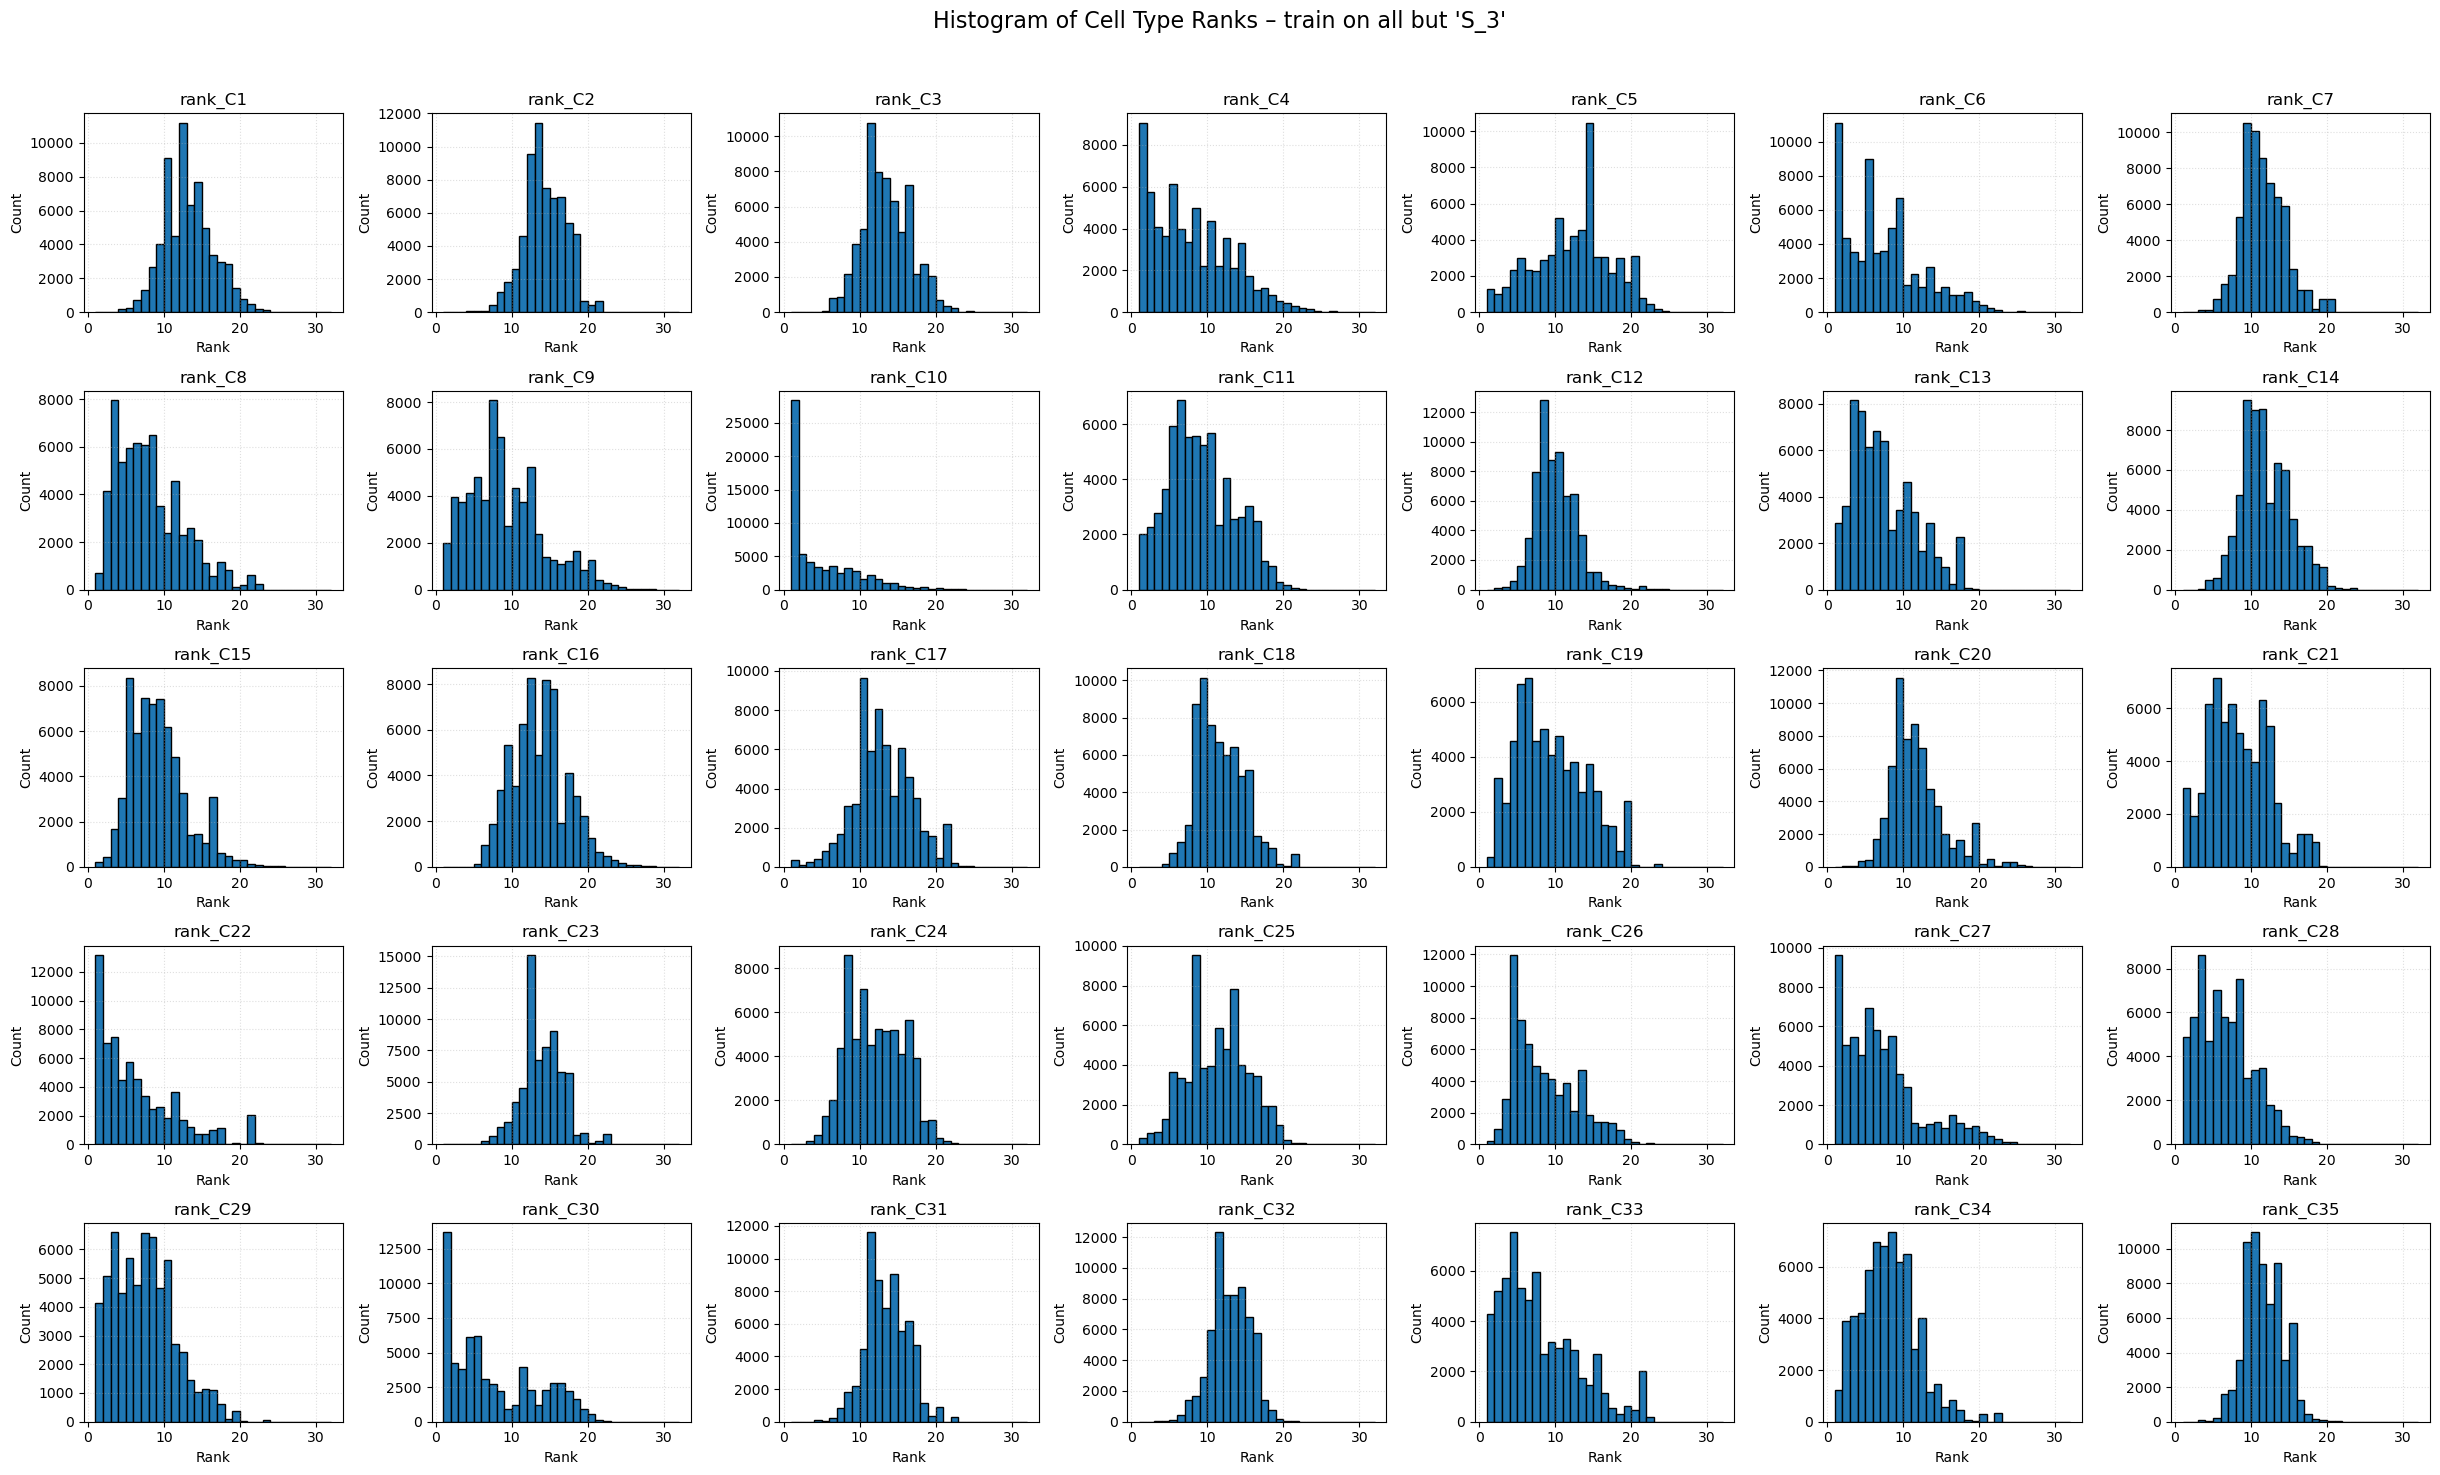

In [104]:
import matplotlib.pyplot as plt
import math

def plot_rank_histograms(df, slide_id=None, rank_cols=None, ncols=5, bins=None):
    """
    为 df 中所有 rank_C* 列画直方图。

    Args:
        df (pd.DataFrame): 包含列 'rank_C1'...'rank_C35' 的 DataFrame（比如 oversampled_dict[slide_id]）。
        slide_id (str, optional): 如果提供，会出现在标题里。
        rank_cols (list[str], optional): 想要画的列名列表，默认自动选所有以 'rank_C' 开头的列。
        ncols (int): 每行子图数，默认 5。
        bins (array-like, optional): 传给 plt.hist 的 bins；默认自动用 1..max+1 的区间。
    """
    # 1) 自动猜要画哪些列
    if rank_cols is None:
        rank_cols = [c for c in df.columns if c.startswith("rank_C")]
    n = len(rank_cols)
    if n == 0:
        raise ValueError("找不到任何以 'rank_C' 开头的列。")

    # 2) 计算子图行数
    nrows = math.ceil(n / ncols)

    # 3) 准备画布
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols * 3.5, nrows * 3),
                             constrained_layout=False)
    axes = axes.flatten()

    # 4) 默认的 bins：整数区间
    if bins is None:
        # 找到所有列的最大值
        max_rank = int(df[rank_cols].values.max())
        bins = range(1, max_rank + 2)

    # 5) 画每个 rank 列
    for ax, col in zip(axes, rank_cols):
        ax.hist(df[col], bins=bins, edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel("Rank")
        ax.set_ylabel("Count")
        ax.grid(True, linestyle=":", alpha=0.4)

    # 6) 关掉多余的子图格子
    for ax in axes[n:]:
        ax.set_visible(False)

    # 7) 总标题
    title = "Histogram of Cell Type Ranks"
    if slide_id is not None:
        title += f" – train on all but '{slide_id}'"
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
df_over_S3 = oversampled_dict['S_3']
plot_rank_histograms(df_over_S3, slide_id='S_3', ncols=7)

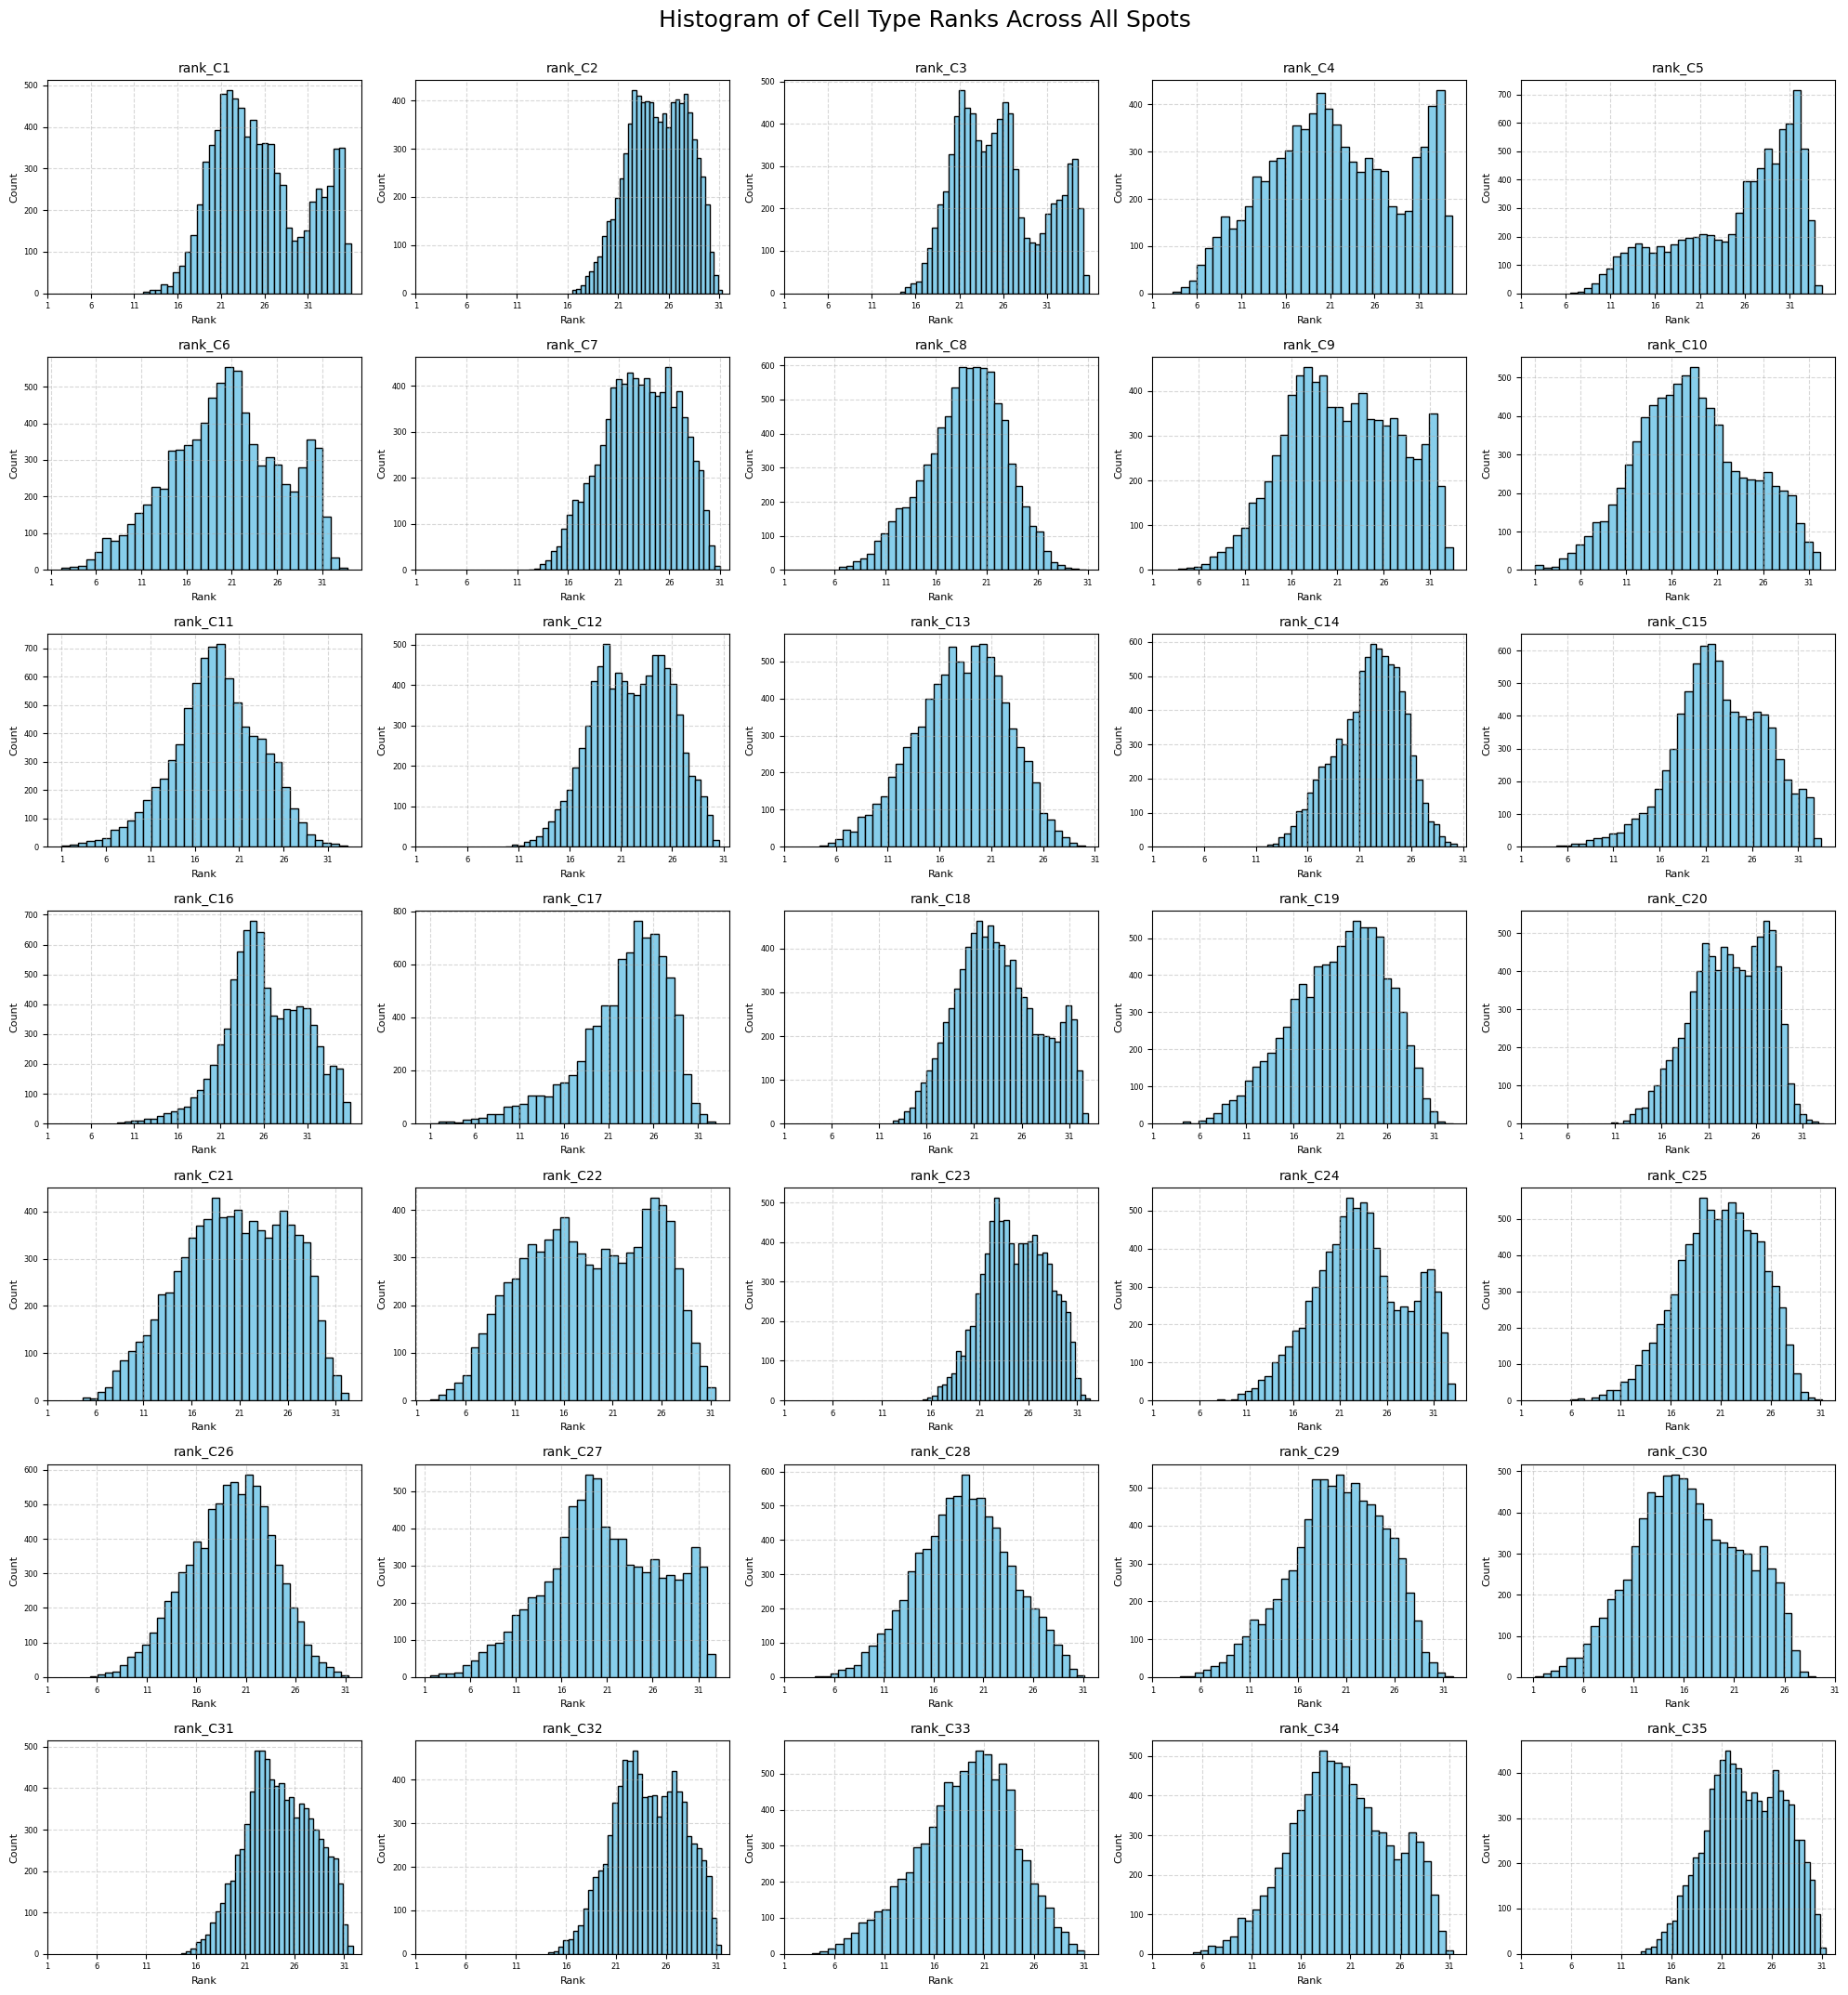

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# 原始資料：filtered_df[zscore_cols] 是 samples × cell types，我們要做 corr → cell × cell
zscore_cols = ["rank_" + col for col in cell_type_cols]
zscore_data = ranked_df[zscore_cols]

# 把欄位名稱簡化（optional，讓圖比較乾淨）
zscore_data.columns = cell_type_cols

# 計算相關矩陣（cell types × cell types）
corr_matrix = zscore_data.corr(method='pearson')  # or 'spearman' if non-normal

# 畫出 correlation heatmap + clustering
sns.clustermap(
    corr_matrix,
    method='ward',      # clustering 方法：ward / average / complete / single
    metric='euclidean', # 或用 'correlation' 做距離
    cmap='vlag',        # 紅藍色調
    figsize=(10, 10),
    annot=False         # 要不要在格子裡寫數字
)
plt.title("Cell Type × Cell Type Correlation Clustermap")
plt.show()


In [14]:
import h5py
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from scipy.stats import rankdata, spearmanr, pearsonr
import matplotlib.pyplot as plt

def gaussian_spatial_smoothing(df, cell_type_cols, radius=80, sigma=None):
    coords = df[["x", "y"]].values
    tree = KDTree(coords)
    sigma = sigma or (radius / 2)
    smoothed = []
    for i in range(len(df)):
        idxs, dists = tree.query_radius([coords[i]], r=radius, return_distance=True)
        idxs = idxs[0]
        dists = dists[0]
        if len(idxs) == 0:
            smoothed.append(df.iloc[i][cell_type_cols].values)
            continue
        weights = np.exp(- (dists ** 2) / (2 * sigma ** 2))
        weights = weights / (weights.sum() + 1e-8)
        neighbor_vals = df.iloc[idxs][cell_type_cols].values
        weighted_vals = np.average(neighbor_vals, axis=0, weights=weights)
        smoothed.append(weighted_vals)
    smoothed_array = np.vstack(smoothed)
    smoothed_df = df.copy()
    smoothed_df[cell_type_cols] = smoothed_array
    return smoothed_df

def plot_cell_expression_comparison_with_round(
    slide_id,
    cell_type,
    original_df,
    radius,
    smoothed_df,
    image_array,
    round_num,
    cmap="plasma"
):
    x = original_df["x"].values
    y = original_df["y"].values
    z_orig = original_df[cell_type].values
    z_smooth = smoothed_df[cell_type].values
    vmin = min(z_orig.min(), z_smooth.min())
    vmax = max(z_orig.max(), z_smooth.max())
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    spearman_corr = spearmanr(z_orig, z_smooth)
    pearson_corr = pearsonr(z_orig, z_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image_array)
    sc1 = axes[0].scatter(x, y, c=z_orig, cmap=cmap, s=15, norm=norm)
    axes[0].set_title(f"{slide_id} - Original")
    axes[0].axis("off")
    plt.colorbar(sc1, ax=axes[0])

    axes[1].imshow(image_array)
    sc2 = axes[1].scatter(x, y, c=z_smooth, cmap=cmap, s=15, norm=norm)
    axes[1].set_title(
        f"{slide_id} - Round {round_num} Smoothed\n"
        f"r={pearson_corr.statistic:.2f}, ρ={spearman_corr.statistic:.2f}"
    )
    axes[1].axis("off")
    plt.colorbar(sc2, ax=axes[1])

    plt.suptitle(f"{cell_type} - Expression Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"▶️ Round {round_num} Pearson r = {pearson_corr.statistic:.4f}, p = {pearson_corr.pvalue:.4g}")
    print(f"▶️ Round {round_num} Spearman ρ = {spearman_corr.statistic:.4f}, p = {spearman_corr.pvalue:.4g}")

def process_slide_smoothing_and_ranking(
    spot_h5_path,
    image_h5_path,
    slide_id,
    cell_prefix="C",
    cell_type_to_plot="C1",
    radius=80,
    rounds=1
):
    if isinstance(slide_id, str):
        slide_ids = [slide_id]
    else:
        slide_ids = slide_id

    # 用來收集每個 slide、每一輪的 correlation 結果
    log = []

    for sid in slide_ids:
        print(f"\n====================== 📌 Slide {sid} ======================\n")

        with h5py.File(spot_h5_path, "r") as f:
            spot_array = np.array(f[f"spots/Train/{sid}"])

        with h5py.File(image_h5_path, "r") as f:
            image_array = np.array(f[f"images/Train/{sid}"])

        df = pd.DataFrame(spot_array)
        df["slide_name"] = sid
        cell_type_cols = [col for col in df.columns if col.startswith(cell_prefix)]

        if cell_type_to_plot not in cell_type_cols:
            raise ValueError(f"❌ '{cell_type_to_plot}' 不在欄位中，請確認 cell_prefix 與 cell_type 名稱！")

        baseline_df = df.copy()
        current_df = df.copy()

        for r in range(rounds):
            print(f"\n🔁 Round {r+1} smoothing with radius = {radius}")
            smoothed_df = gaussian_spatial_smoothing(current_df, cell_type_cols, radius=radius)

            # 排名
            ranked_values = smoothed_df[cell_type_cols].apply(
                lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
            )
            ranked_values.columns = cell_type_cols
            ranked_df = pd.concat([smoothed_df.drop(columns=cell_type_cols), ranked_values], axis=1)

            # 所有 cell type correlation 平均
            pearsons = []
            spearmans = []
            for col in cell_type_cols:
                r_pear = pearsonr(baseline_df[col], smoothed_df[col]).statistic
                r_spear = spearmanr(baseline_df[col], smoothed_df[col]).statistic
                pearsons.append(r_pear)
                spearmans.append(r_spear)

            avg_p = np.mean(pearsons)
            avg_s = np.mean(spearmans)
            print(f"📊 Slide {sid} - Round {r+1} - Avg Pearson r = {avg_p:.4f}, Avg Spearman ρ = {avg_s:.4f}")

            # 指定 cell type correlation
            cell_p = pearsonr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            cell_s = spearmanr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            print(f"🔍 {sid} - {cell_type_to_plot} - Pearson: {cell_p.statistic:.4f}, Spearman: {cell_s.statistic:.4f}")

            # 畫圖
            plot_cell_expression_comparison_with_round(
                slide_id=sid,
                cell_type=cell_type_to_plot,
                original_df=baseline_df,
                radius=radius,
                smoothed_df=smoothed_df,
                image_array=image_array,
                round_num=r+1
            )

            # 記錄這一輪結果
            log.append({
                "slide": sid,
                "round": r+1,
                "cell_type": cell_type_to_plot,
                "cell_type_pearson": cell_p.statistic,
                "cell_type_spearman": cell_s.statistic,
                "avg_pearson": avg_p,
                "avg_spearman": avg_s
            })

            current_df = smoothed_df.copy()

        print(f"\n✅ Slide {sid} 完成 {rounds} 輪 smoothing + 排名 + correlation 分析")

    # 建成 dataframe 並顯示每個 slide 的平均 correlation
    log_df = pd.DataFrame(log)
    print("\n================== 📈 Overall Slide-level Average Correlation ==================\n")
    summary = log_df.groupby("slide")[["cell_type_pearson", "cell_type_spearman", "avg_pearson", "avg_spearman"]].mean()
    print(summary.round(4))

    return log_df



====================== 📌 Slide S_1 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_1 - Round 1 - Avg Pearson r = 0.9018, Avg Spearman ρ = 0.8754
🔍 S_1 - rank_C8 - Pearson: 0.7011, Spearman: 0.6520


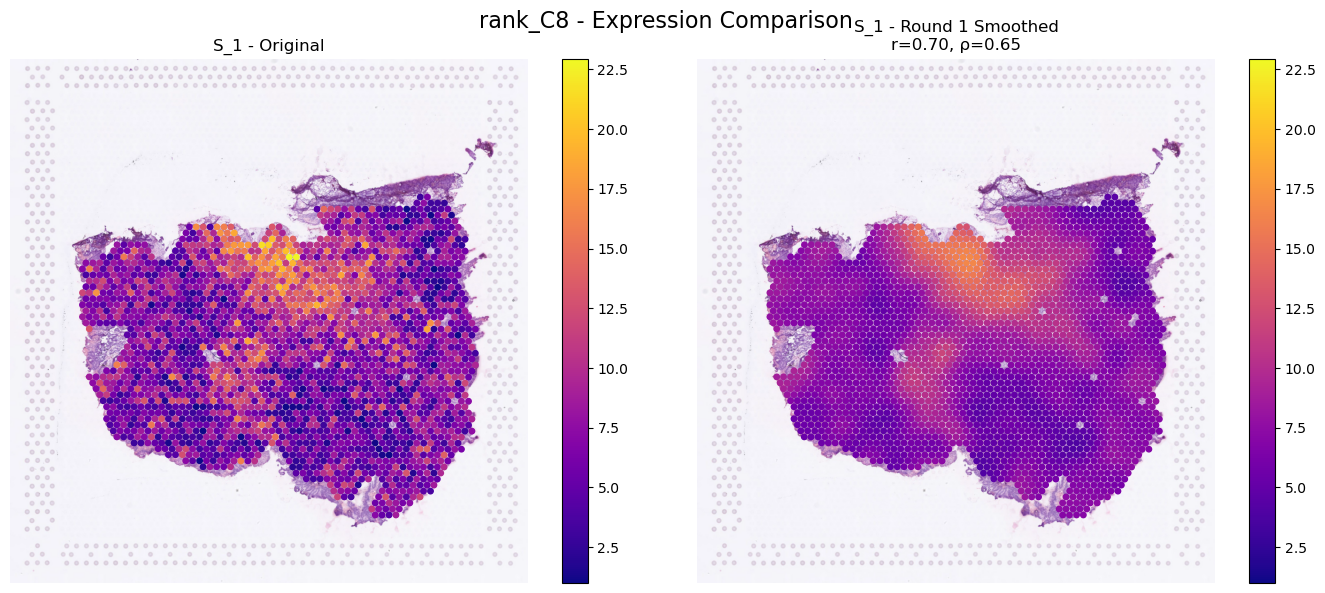

▶️ Round 1 Pearson r = 0.7011, p = 0
▶️ Round 1 Spearman ρ = 0.6520, p = 3.464e-266

✅ Slide S_1 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_2 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_2 - Round 1 - Avg Pearson r = 0.9350, Avg Spearman ρ = 0.9283
🔍 S_2 - rank_C8 - Pearson: 0.4877, Spearman: 0.4221


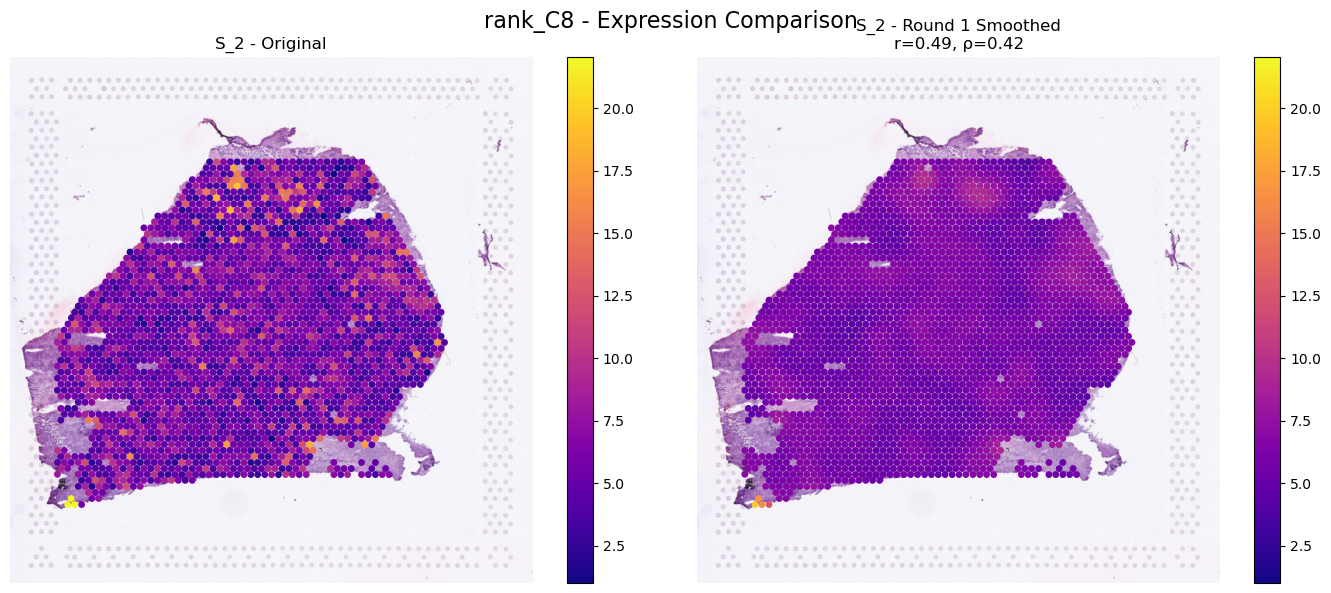

▶️ Round 1 Pearson r = 0.4877, p = 6.278e-136
▶️ Round 1 Spearman ρ = 0.4221, p = 1.002e-98

✅ Slide S_2 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_3 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_3 - Round 1 - Avg Pearson r = 0.8397, Avg Spearman ρ = 0.8268
🔍 S_3 - rank_C8 - Pearson: 0.4607, Spearman: 0.4848


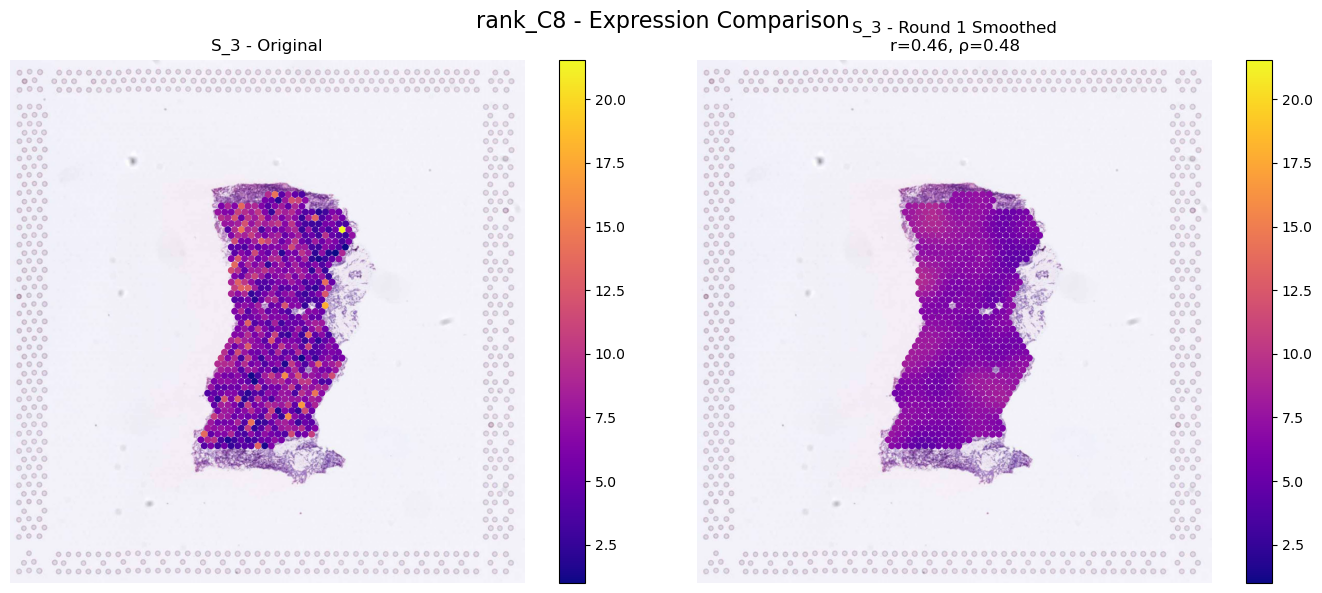

▶️ Round 1 Pearson r = 0.4607, p = 1.519e-37
▶️ Round 1 Spearman ρ = 0.4848, p = 5.941e-42

✅ Slide S_3 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_4 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_4 - Round 1 - Avg Pearson r = 0.8951, Avg Spearman ρ = 0.8708
🔍 S_4 - rank_C8 - Pearson: 0.5754, Spearman: 0.5525


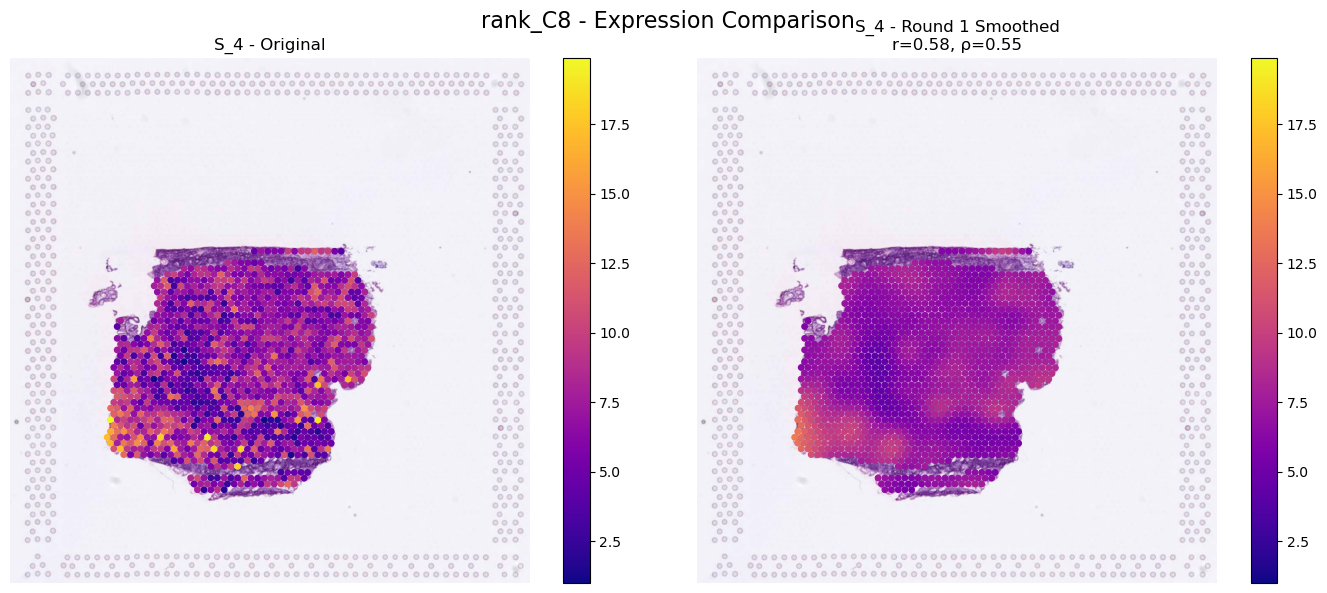

▶️ Round 1 Pearson r = 0.5754, p = 1.37e-105
▶️ Round 1 Spearman ρ = 0.5525, p = 8.252e-96

✅ Slide S_4 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_5 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_5 - Round 1 - Avg Pearson r = 0.8965, Avg Spearman ρ = 0.8786
🔍 S_5 - rank_C8 - Pearson: 0.7143, Spearman: 0.7181


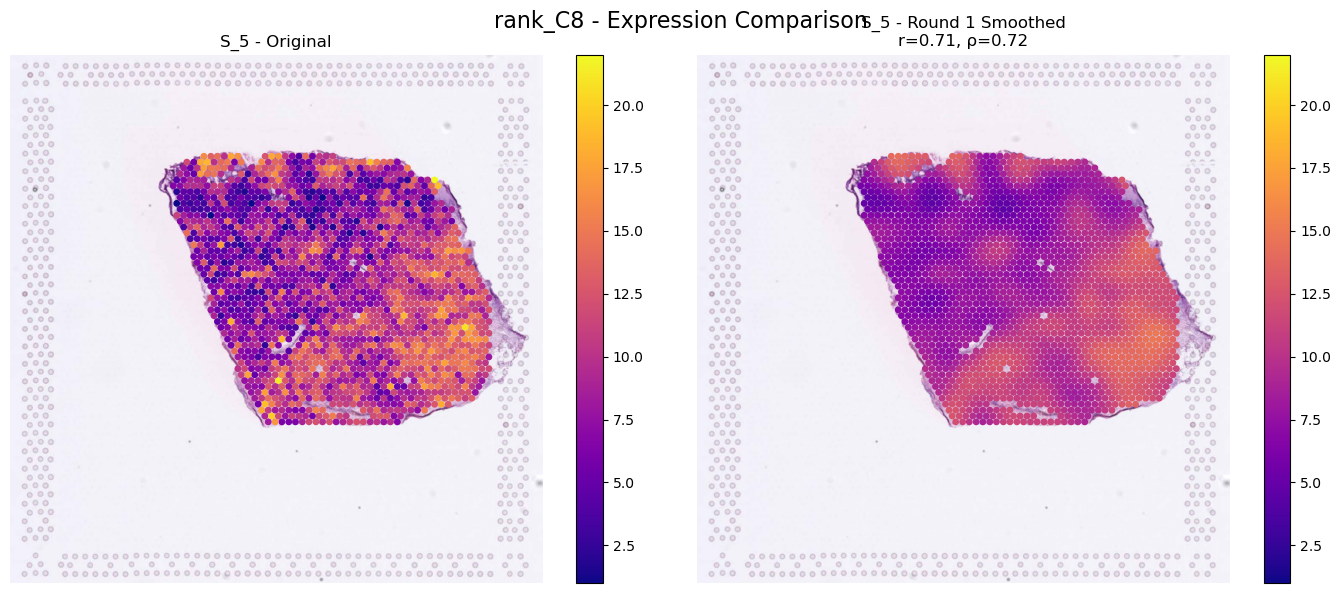

▶️ Round 1 Pearson r = 0.7143, p = 6.763e-262
▶️ Round 1 Spearman ρ = 0.7181, p = 6.124e-266

✅ Slide S_5 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_6 ======================


🔁 Round 1 smoothing with radius = 78
📊 Slide S_6 - Round 1 - Avg Pearson r = 0.9113, Avg Spearman ρ = 0.8877
🔍 S_6 - rank_C8 - Pearson: 0.5562, Spearman: 0.5377


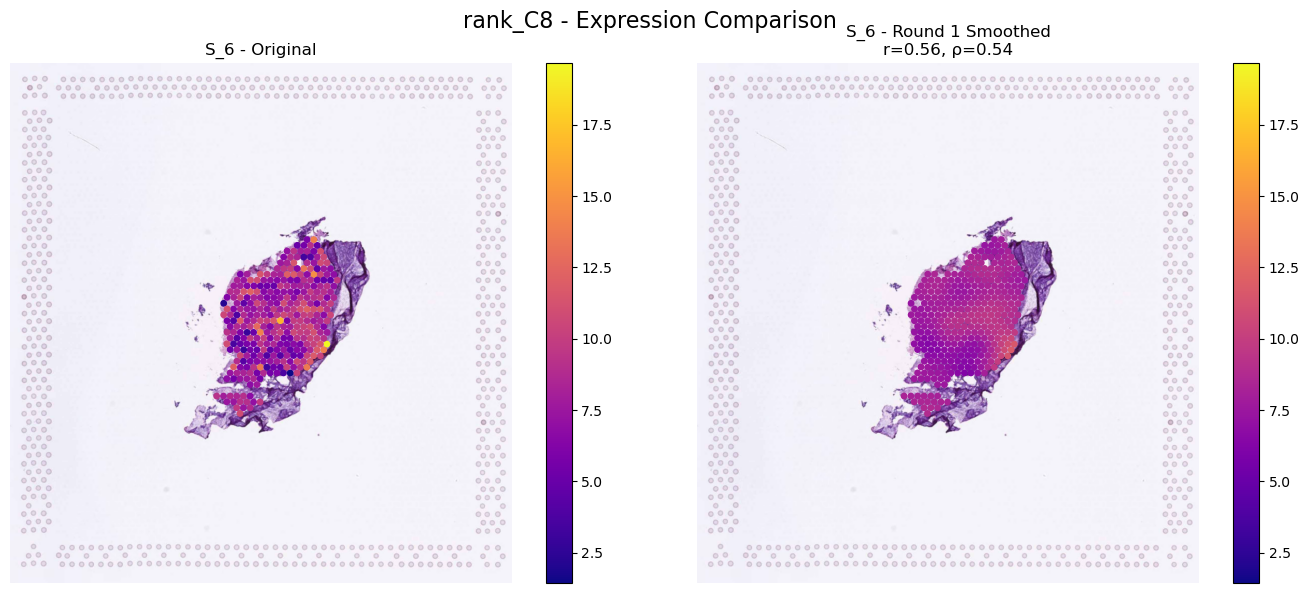

▶️ Round 1 Pearson r = 0.5562, p = 4.94e-28
▶️ Round 1 Spearman ρ = 0.5377, p = 5.712e-26

✅ Slide S_6 完成 1 輪 smoothing + 排名 + correlation 分析

================== 📈 Overall Slide-level Average Correlation ==================

       cell_type_pearson  cell_type_spearman  avg_pearson  avg_spearman
slide                                                                  
S_1               0.7011              0.6520       0.9018        0.8754
S_2               0.4877              0.4221       0.9350        0.9283
S_3               0.4607              0.4848       0.8397        0.8268
S_4               0.5754              0.5525       0.8951        0.8708
S_5               0.7143              0.7181       0.8965        0.8786
S_6               0.5562              0.5377       0.9113        0.8877


slide  round cell_type  cell_type_pearson  cell_type_spearman  avg_pearson  \
0   S_1      1   rank_C8           0.701096            0.652024     0.901753   
1   S_2      1   rank_C8           0.487747            0.422106     0.934973   
2   S_3      1   rank_C8           0.460668            0.484774     0.839699   
3   S_4      1   rank_C8           0.575399            0.552467     0.895080   
4   S_5      1   rank_C8           0.714279            0.718057     0.896538   
5   S_6      1   rank_C8           0.556211            0.537673     0.911348   

   avg_spearman  
0      0.875399  
1      0.928291  
2      0.826782  
3      0.870756  
4      0.878556  
5      0.887722

In [22]:
import h5py
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from scipy.stats import rankdata, spearmanr, pearsonr
import matplotlib.pyplot as plt

def gaussian_spatial_smoothing(df, cell_type_cols, radius=80, sigma=None):
    coords = df[["x", "y"]].values
    tree = KDTree(coords)
    sigma = sigma or (radius / 2)
    smoothed = []
    for i in range(len(df)):
        idxs, dists = tree.query_radius([coords[i]], r=radius, return_distance=True)
        idxs = idxs[0]
        dists = dists[0]
        if len(idxs) == 0:
            smoothed.append(df.iloc[i][cell_type_cols].values)
            continue
        weights = np.exp(- (dists ** 2) / (2 * sigma ** 2))
        weights = weights / (weights.sum() + 1e-8)
        neighbor_vals = df.iloc[idxs][cell_type_cols].values
        weighted_vals = np.average(neighbor_vals, axis=0, weights=weights)
        smoothed.append(weighted_vals)
    smoothed_array = np.vstack(smoothed)
    smoothed_df = df.copy()
    smoothed_df[cell_type_cols] = smoothed_array
    return smoothed_df

def plot_cell_expression_comparison_with_round(
    slide_id,
    cell_type,
    original_df,
    radius,
    smoothed_df,
    image_array,
    round_num,
    cmap="plasma"
):
    x = original_df["x"].values
    y = original_df["y"].values
    z_orig = original_df[cell_type].values
    z_smooth = smoothed_df[cell_type].values
    vmin = min(z_orig.min(), z_smooth.min())
    vmax = max(z_orig.max(), z_smooth.max())
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    spearman_corr = spearmanr(z_orig, z_smooth)
    pearson_corr = pearsonr(z_orig, z_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image_array)
    sc1 = axes[0].scatter(x, y, c=z_orig, cmap=cmap, s=15, norm=norm)
    axes[0].set_title(f"{slide_id} - Original")
    axes[0].axis("off")
    plt.colorbar(sc1, ax=axes[0])

    axes[1].imshow(image_array)
    sc2 = axes[1].scatter(x, y, c=z_smooth, cmap=cmap, s=15, norm=norm)
    axes[1].set_title(
        f"{slide_id} - Round {round_num} Smoothed\n"
        f"r={pearson_corr.statistic:.2f}, ρ={spearman_corr.statistic:.2f}"
    )
    axes[1].axis("off")
    plt.colorbar(sc2, ax=axes[1])

    plt.suptitle(f"{cell_type} - Expression Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"▶️ Round {round_num} Pearson r = {pearson_corr.statistic:.4f}, p = {pearson_corr.pvalue:.4g}")
    print(f"▶️ Round {round_num} Spearman ρ = {spearman_corr.statistic:.4f}, p = {spearman_corr.pvalue:.4g}")

def process_slide_smoothing_and_ranking(
    spot_h5_path,
    image_h5_path,
    slide_id,
    cell_prefix="C",
    cell_type_to_plot="C1",
    radius=80,
    rounds=1
):
    if isinstance(slide_id, str):
        slide_ids = [slide_id]
    else:
        slide_ids = slide_id

    # 用來收集每個 slide、每一輪的 correlation 結果
    log = []

    for sid in slide_ids:
        print(f"\n====================== 📌 Slide {sid} ======================\n")

        with h5py.File(spot_h5_path, "r") as f:
            spot_array = np.array(f[f"spots/Train/{sid}"])

        with h5py.File(image_h5_path, "r") as f:
            image_array = np.array(f[f"images/Train/{sid}"])

        df = pd.DataFrame(spot_array)
        df["slide_name"] = sid
        cell_type_cols = [col for col in df.columns if col.startswith(cell_prefix)]

        if cell_type_to_plot not in cell_type_cols:
            raise ValueError(f"❌ '{cell_type_to_plot}' 不在欄位中，請確認 cell_prefix 與 cell_type 名稱！")

        baseline_df = df.copy()
        current_df = df.copy()

        for r in range(rounds):
            print(f"\n🔁 Round {r+1} smoothing with radius = {radius}")
            smoothed_df = gaussian_spatial_smoothing(current_df, cell_type_cols, radius=radius)

            # 排名
            ranked_values = smoothed_df[cell_type_cols].apply(
                lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
            )
            ranked_values.columns = cell_type_cols
            ranked_df = pd.concat([smoothed_df.drop(columns=cell_type_cols), ranked_values], axis=1)

            # 所有 cell type correlation 平均
            spot_pearsons = []
            spot_spearmans = []
            for i in range(len(baseline_df)):
                z_orig   = baseline_df.iloc[i][cell_type_cols].values
                z_smooth = smoothed_df   .iloc[i][cell_type_cols].values
                spot_pearsons.append( pearsonr(z_orig, z_smooth).statistic )
                spot_spearmans.append( spearmanr(z_orig, z_smooth).statistic )
            avg_p = np.nanmean(spot_pearsons)
            avg_s = np.nanmean(spot_spearmans)
            print(f"📊 Slide {sid} - Round {r+1} - Avg Pearson r = {avg_p:.4f}, Avg Spearman ρ = {avg_s:.4f}")

            # 指定 cell type correlation
            cell_p = pearsonr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            cell_s = spearmanr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            print(f"🔍 {sid} - {cell_type_to_plot} - Pearson: {cell_p.statistic:.4f}, Spearman: {cell_s.statistic:.4f}")

            # 畫圖
            plot_cell_expression_comparison_with_round(
                slide_id=sid,
                cell_type=cell_type_to_plot,
                original_df=baseline_df,
                radius=radius,
                smoothed_df=smoothed_df,
                image_array=image_array,
                round_num=r+1
            )

            # 記錄這一輪結果
            log.append({
                "slide": sid,
                "round": r+1,
                "cell_type": cell_type_to_plot,
                "cell_type_pearson": cell_p.statistic,
                "cell_type_spearman": cell_s.statistic,
                "avg_pearson": avg_p,
                "avg_spearman": avg_s
            })

            current_df = smoothed_df.copy()

        print(f"\n✅ Slide {sid} 完成 {rounds} 輪 smoothing + 排名 + correlation 分析")

    # 建成 dataframe 並顯示每個 slide 的平均 correlation
    log_df = pd.DataFrame(log)
    print("\n================== 📈 Overall Slide-level Average Correlation ==================\n")
    summary = log_df.groupby("slide")[["cell_type_pearson", "cell_type_spearman", "avg_pearson", "avg_spearman"]].mean()
    print(summary.round(4))

    return log_df


process_slide_smoothing_and_ranking(
    spot_h5_path="dataset/realign/log2_nor_rank_spots.h5",
    image_h5_path="./dataset/elucidata_ai_challenge_data.h5",
    slide_id=["S_1", "S_2", "S_3","S_4", "S_5", "S_6"],  # ✅ 傳 list 會依序處理每個 slide
    cell_prefix="rank_C",             # 例如處理 C1~C35
    cell_type_to_plot="rank_C8",     # 但只畫出 C14
    radius=78,
    rounds=1
)


In [29]:
def process_all_cell_types(
    spot_h5_path,
    image_h5_path,
    slide_ids,
    cell_prefix="rank_C",
    radius=80
):
    """
    对每个 slide（或一个 slide 列表）上的所有 cell type 做一次 smoothing，
    并返回每个 cell type 两组指标：
      - cell_type_pearson / spearman：该 cell type 在所有 spot 上的相关
      - avg_pearson / spearman：spot level 的平均相关
    """
    if isinstance(slide_ids, str):
        slide_ids = [slide_ids]

    logs = []
    for sid in slide_ids:
        # 读取 spot table 和 image（image 只用于可视化 optional，此处不绘图）
        with h5py.File(spot_h5_path, "r") as f:
            spots = np.array(f[f"spots/Train/{sid}"])
        df = pd.DataFrame(spots)
        df["slide"] = sid
        # 确保有 x,y
        assert "x" in df and "y" in df

        cell_cols = [c for c in df.columns if c.startswith(cell_prefix)]
        # 基准 DF
        baseline_df = df.copy()

        # 执行平滑一次
        smoothed_df = gaussian_spatial_smoothing(df, cell_cols, radius=radius)

        # 对每个 spot 计算 35 维向量的 Pearson/Spearman
        spot_ps = []
        spot_ss = []
        for i in range(len(baseline_df)):
            z0 = baseline_df.iloc[i][cell_cols].values
            z1 = smoothed_df   .iloc[i][cell_cols].values
            spot_ps.append( pearsonr(z0, z1).statistic )
            spot_ss.append( spearmanr(z0, z1).statistic )
        avg_p = np.nanmean(spot_ps)
        avg_s = np.nanmean(spot_ss)

        # 对每个 cell type 计算整体相关
        for ct in cell_cols:
            p_ct = pearsonr(baseline_df[ct], smoothed_df[ct]).statistic
            s_ct = spearmanr(baseline_df[ct], smoothed_df[ct]).statistic

            logs.append({
                "slide": sid,
                "cell_type": ct,
                "cell_type_pearson": p_ct,
                "cell_type_spearman": s_ct,
                "avg_spot_pearson": avg_p,
                "avg_spot_spearman": avg_s
            })

    result_df = pd.DataFrame(logs)
    return result_df

# 用法示例
df_metrics = process_all_cell_types(
    spot_h5_path    = "dataset/realign/log2_nor_rank_spots.h5",
    image_h5_path   = "./dataset/elucidata_ai_challenge_data.h5",  # （本函数不直接使用 image）
    slide_ids       = ["S_1","S_2","S_3","S_4","S_5","S_6"],
    cell_prefix     = "rank_C",
    radius          = 40
)

In [30]:
df_metrics

slide cell_type  cell_type_pearson  cell_type_spearman  avg_spot_pearson  \
0     S_1   rank_C1           0.786838            0.778970          0.941507   
1     S_1   rank_C2           0.826596            0.809121          0.941507   
2     S_1   rank_C3           0.802136            0.793004          0.941507   
3     S_1   rank_C4           0.755312            0.737303          0.941507   
4     S_1   rank_C5           0.888428            0.880662          0.941507   
..    ...       ...                ...                 ...               ...   
205   S_6  rank_C31           0.833088            0.817793          0.952727   
206   S_6  rank_C32           0.832272            0.815815          0.952727   
207   S_6  rank_C33           0.774456            0.725961          0.952727   
208   S_6  rank_C34           0.787633            0.772319          0.952727   
209   S_6  rank_C35           0.823685            0.810548          0.952727   

     avg_spot_spearman  
0             0.919980  
1             0.919980  
2             0.919980  
3             0.919980  
4             0.919980  
..                 ...  
205           0.934656  
206           0.934656  
207           0.934656  
208           0.934656  
209           0.934656  

[210 rows x 6 columns]


====================== 📌 Slide S_1 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_1 - Round 1 - Avg Pearson r = 0.8478, Avg Spearman ρ = 0.8341
🔍 S_1 - rank_C8 - Pearson: 0.7409, Spearman: 0.7247


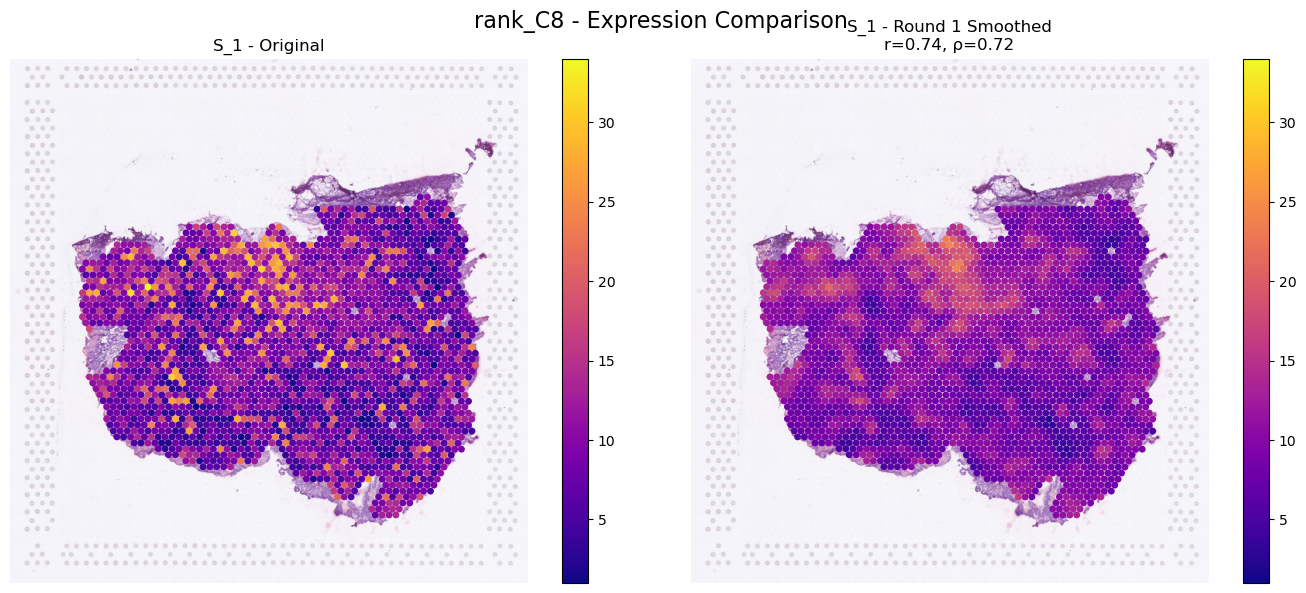

▶️ Round 1 Pearson r = 0.7409, p = 0
▶️ Round 1 Spearman ρ = 0.7247, p = 0

✅ Slide S_1 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_2 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_2 - Round 1 - Avg Pearson r = 0.8391, Avg Spearman ρ = 0.7974
🔍 S_2 - rank_C8 - Pearson: 0.7467, Spearman: 0.6506


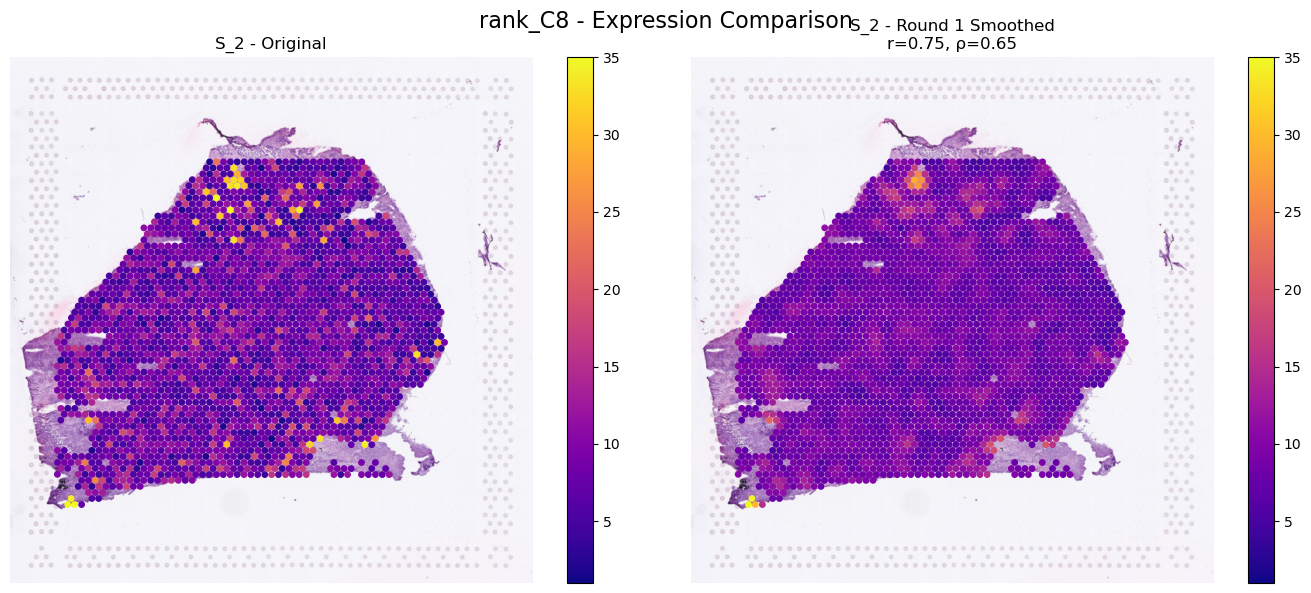

▶️ Round 1 Pearson r = 0.7467, p = 0
▶️ Round 1 Spearman ρ = 0.6506, p = 2.853e-273

✅ Slide S_2 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_3 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_3 - Round 1 - Avg Pearson r = 0.7926, Avg Spearman ρ = 0.7650
🔍 S_3 - rank_C8 - Pearson: 0.7032, Spearman: 0.6694


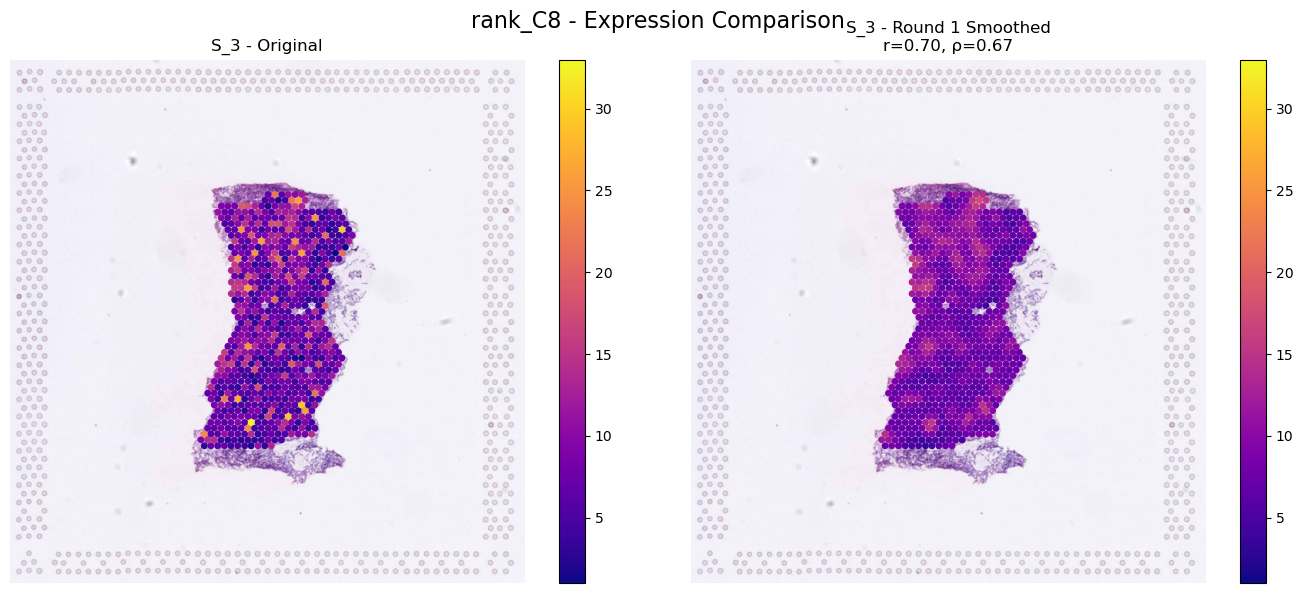

▶️ Round 1 Pearson r = 0.7032, p = 5.229e-104
▶️ Round 1 Spearman ρ = 0.6694, p = 7.038e-91

✅ Slide S_3 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_4 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_4 - Round 1 - Avg Pearson r = 0.8724, Avg Spearman ρ = 0.8595
🔍 S_4 - rank_C8 - Pearson: 0.7027, Spearman: 0.6795


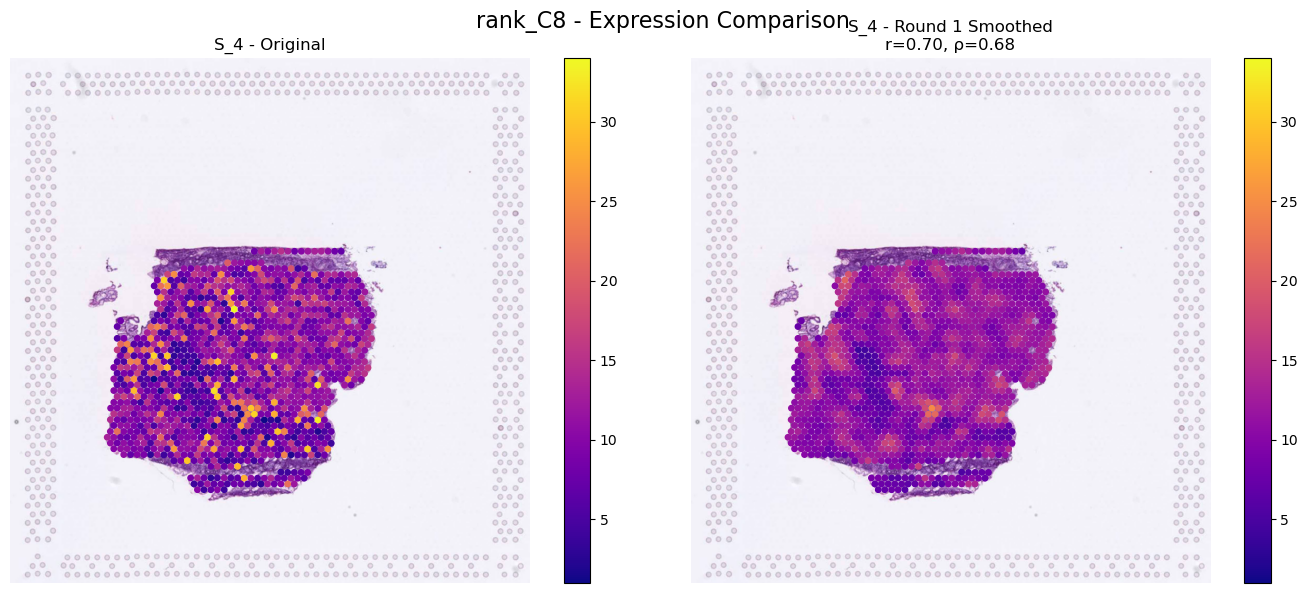

▶️ Round 1 Pearson r = 0.7027, p = 2.01e-177
▶️ Round 1 Spearman ρ = 0.6795, p = 1.494e-161

✅ Slide S_4 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_5 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_5 - Round 1 - Avg Pearson r = 0.8547, Avg Spearman ρ = 0.8371
🔍 S_5 - rank_C8 - Pearson: 0.7896, Spearman: 0.8002


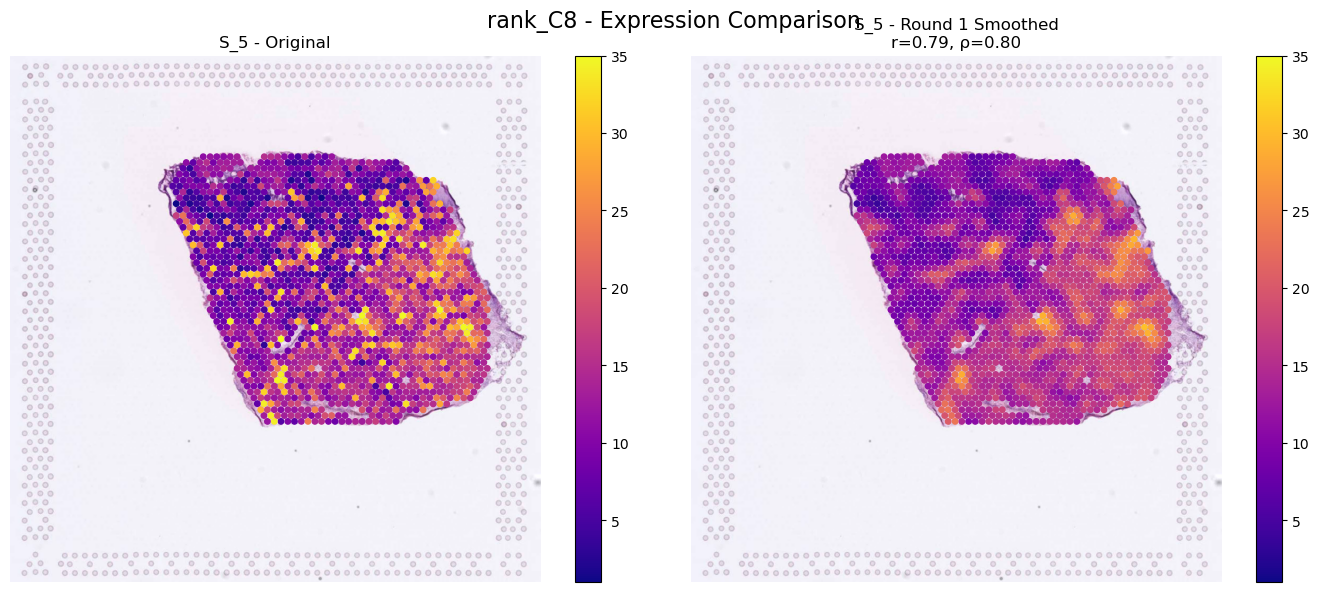

▶️ Round 1 Pearson r = 0.7896, p = 0
▶️ Round 1 Spearman ρ = 0.8002, p = 0

✅ Slide S_5 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_6 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_6 - Round 1 - Avg Pearson r = 0.8291, Avg Spearman ρ = 0.8197
🔍 S_6 - rank_C8 - Pearson: 0.7094, Spearman: 0.7001


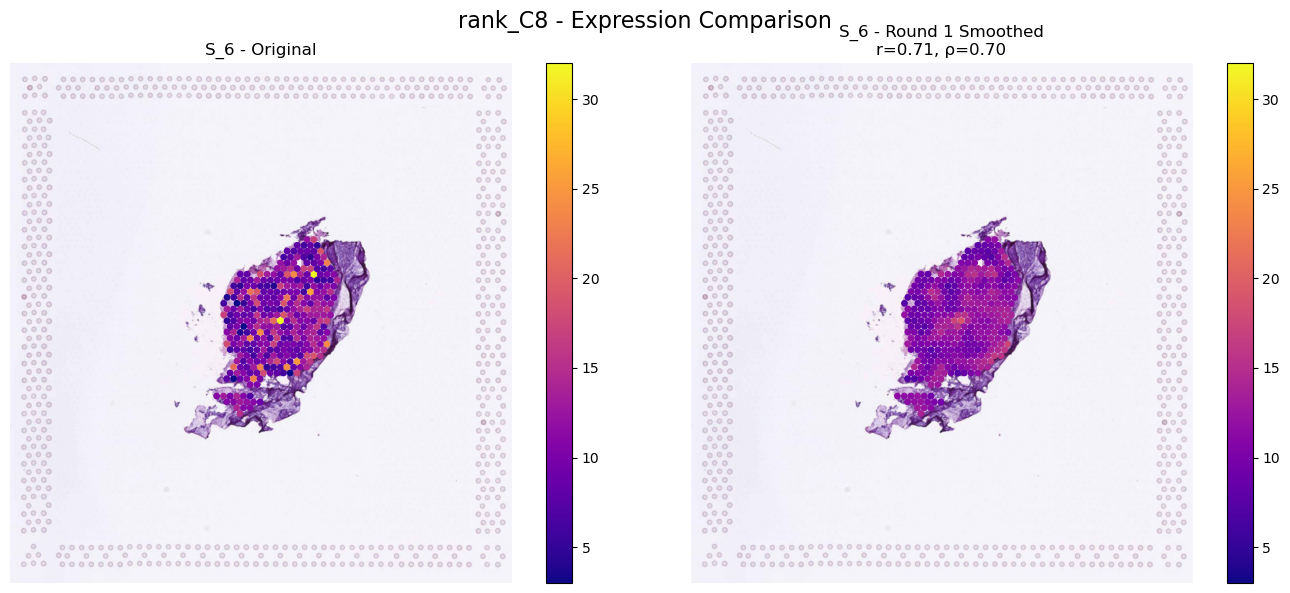

▶️ Round 1 Pearson r = 0.7094, p = 1.827e-51
▶️ Round 1 Spearman ρ = 0.7001, p = 1.322e-49

✅ Slide S_6 完成 1 輪 smoothing + 排名 + correlation 分析

================== 📈 Overall Slide-level Average Correlation ==================

       cell_type_pearson  cell_type_spearman  avg_pearson  avg_spearman
slide                                                                  
S_1               0.7409              0.7247       0.8478        0.8341
S_2               0.7467              0.6506       0.8391        0.7974
S_3               0.7032              0.6694       0.7926        0.7650
S_4               0.7027              0.6795       0.8724        0.8595
S_5               0.7896              0.8002       0.8547        0.8371
S_6               0.7094              0.7001       0.8291        0.8197


slide  round cell_type  cell_type_pearson  cell_type_spearman  avg_pearson  \
0   S_1      1   rank_C8           0.740869            0.724671     0.847814   
1   S_2      1   rank_C8           0.746693            0.650608     0.839111   
2   S_3      1   rank_C8           0.703200            0.669428     0.792586   
3   S_4      1   rank_C8           0.702745            0.679470     0.872394   
4   S_5      1   rank_C8           0.789634            0.800210     0.854674   
5   S_6      1   rank_C8           0.709408            0.700058     0.829127   

   avg_spearman  
0      0.834139  
1      0.797436  
2      0.764980  
3      0.859478  
4      0.837107  
5      0.819723

In [13]:

process_slide_smoothing_and_ranking(
    spot_h5_path="dataset/realign/spot-rank/version-1/directly_rank_train_spots.h5",
    image_h5_path="./dataset/elucidata_ai_challenge_data.h5",
    slide_id=["S_1", "S_2", "S_3","S_4", "S_5", "S_6"],  # ✅ 傳 list 會依序處理每個 slide
    cell_prefix="rank_C",             # 例如處理 C1~C35
    cell_type_to_plot="rank_C8",     # 但只畫出 C14
    radius=40,
    rounds=1
)


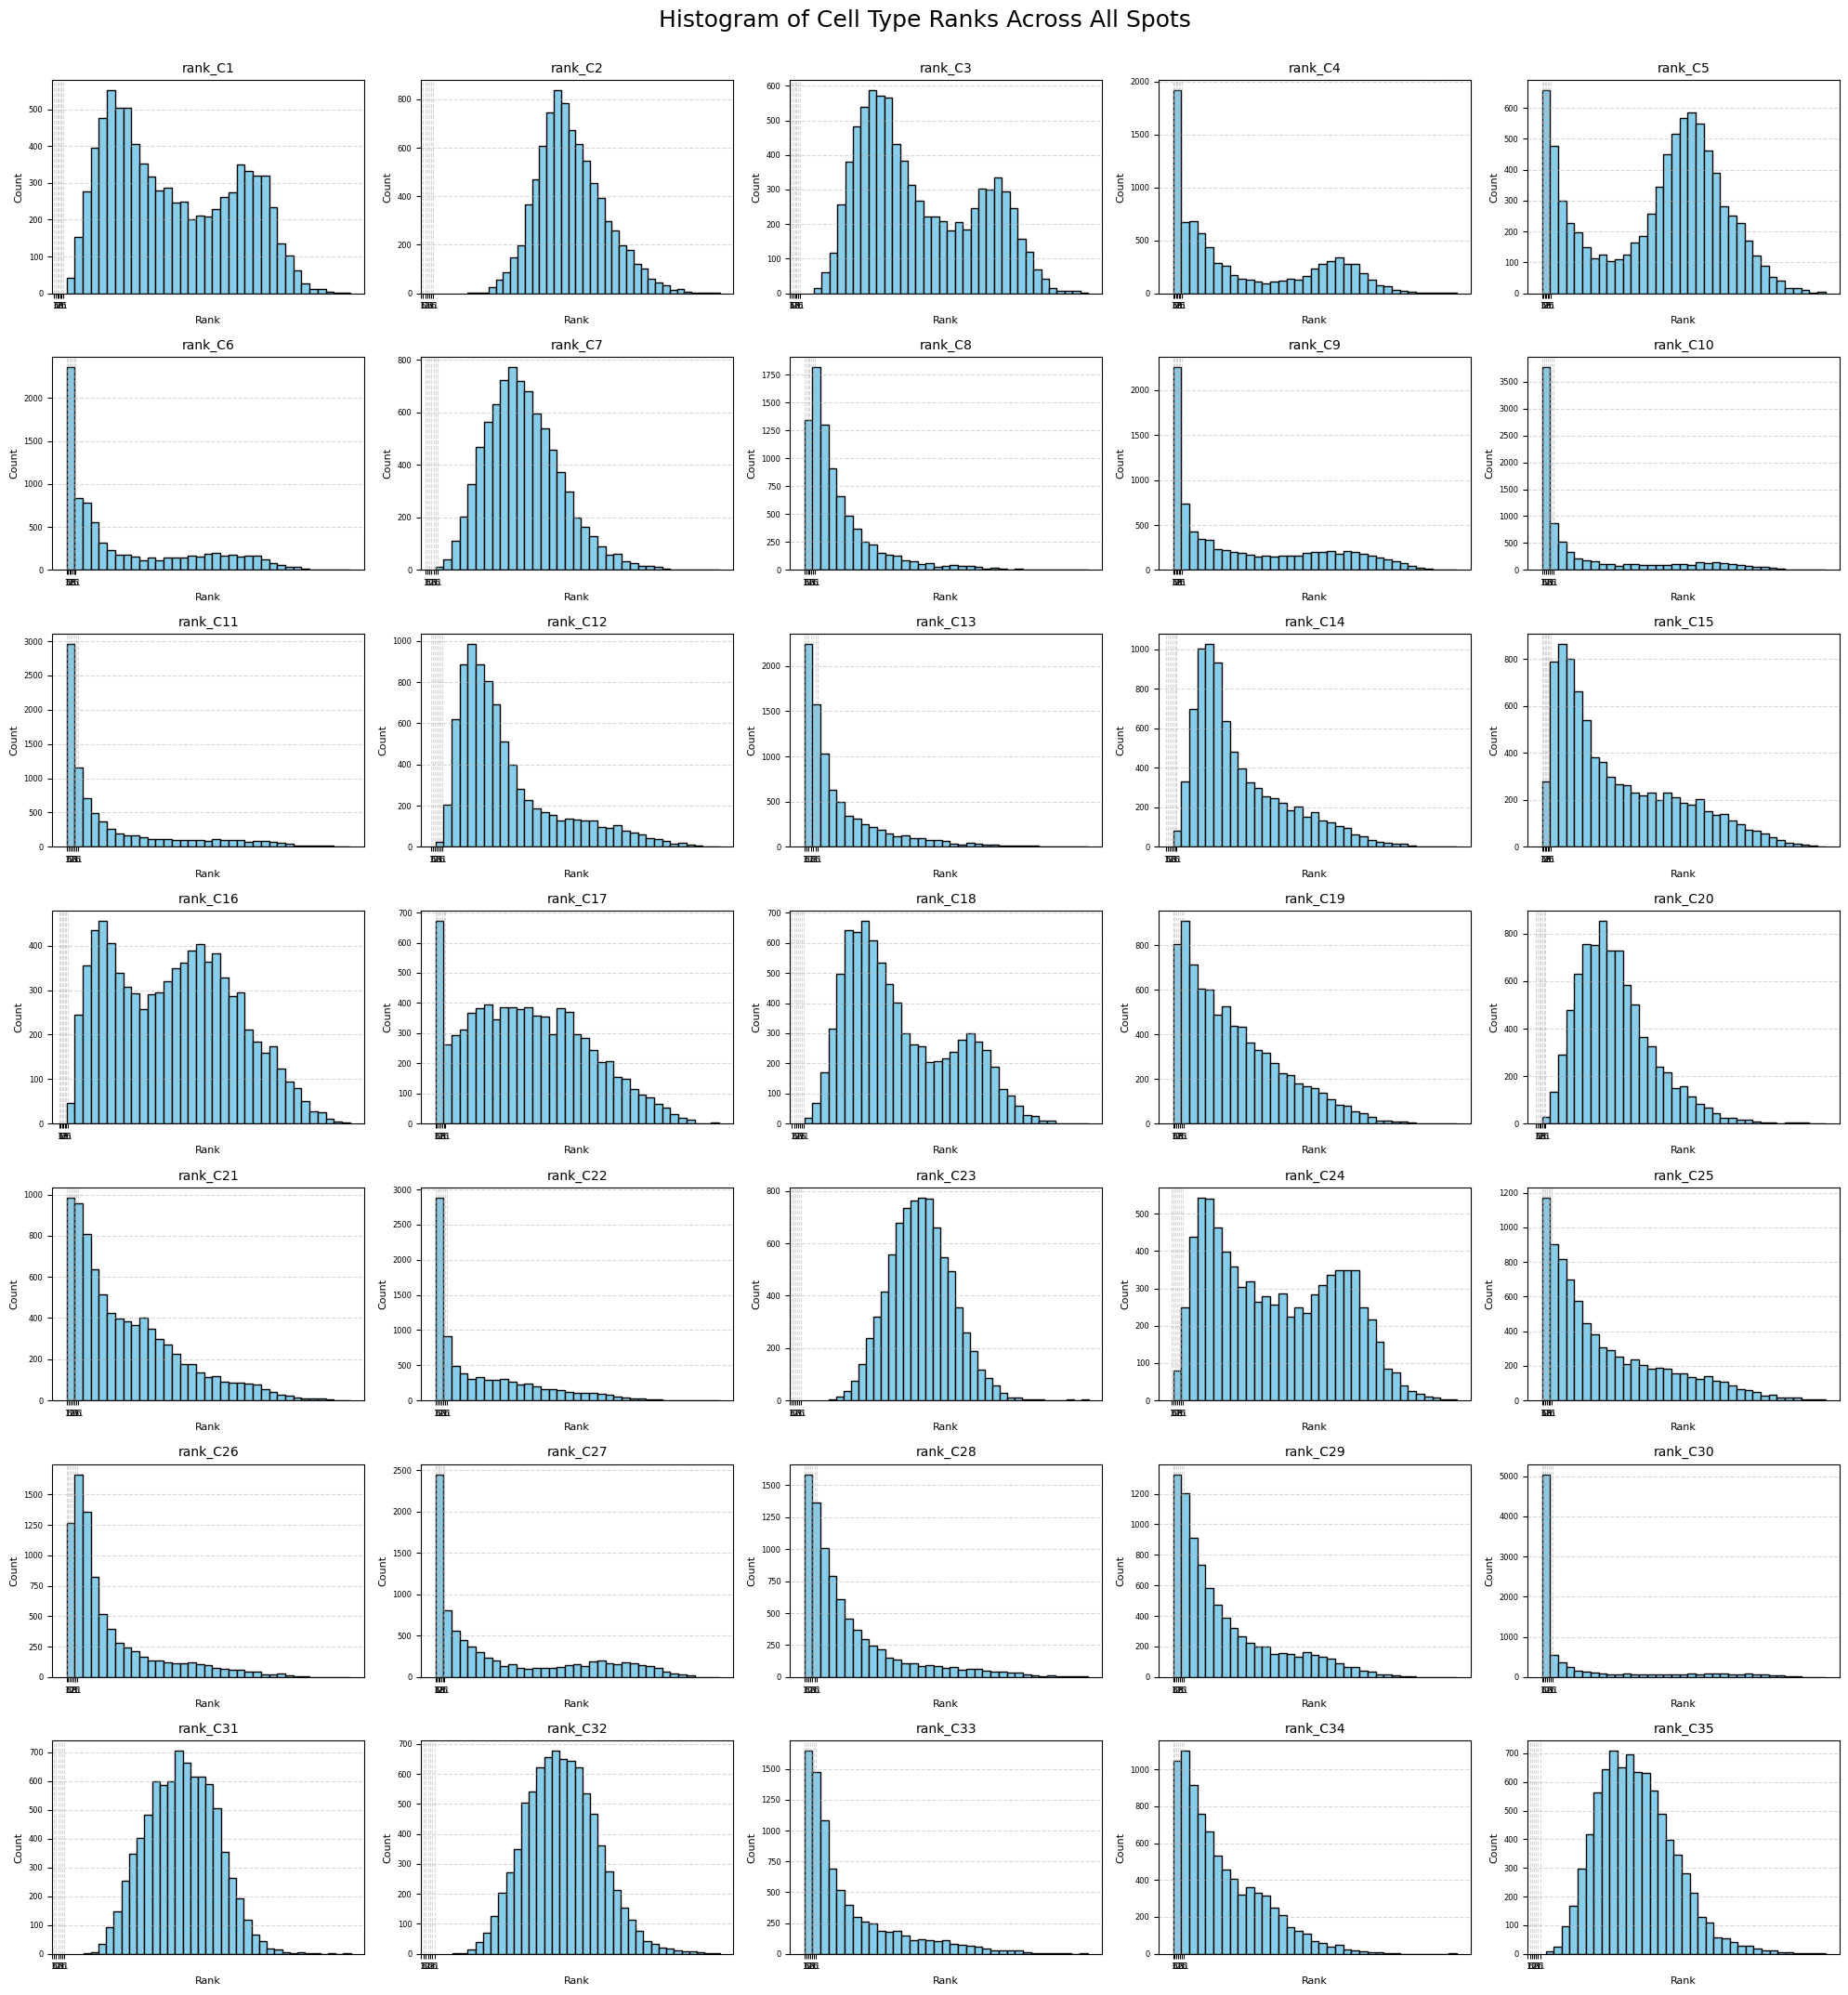

In [42]:
import matplotlib.pyplot as plt
import math

# 所有排名欄位
rank_cols = [col for col in ranked_df.columns if col.startswith("rank_")]
n_plots = len(rank_cols)

# 設定 subplot 的行與列數（例如每列 5 張圖）
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

# 建立畫布
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(rank_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(ranked_df[col], bins=35, color='skyblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.xlabel("Rank", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.xticks(range(1, 36, 5), fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Histogram of Cell Type Ranks Across All Spots", fontsize=18, y=1.02)
plt.show()


## Save data

In [6]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "dataset/spot-rank/version-4/realign/log2_nor_rank_spots/realign_all/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "log2_nor_rank_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：dataset/spot-rank/version-4/realign/log2_nor_rank_spots/realign_all/log2_nor_rank_spots.h5


In [20]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-v/no_realgin/filtered&masked/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "log2_nor_rank_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-v/no_realgin/filtered&masked/log2_nor_rank_spots.h5


In [47]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-3/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "rank_times_expr_train_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-3/rank_times_expr_train_spots.h5


In [91]:
from python_scripts.expression_plot_utils import plot_cell_expression_on_slide
plot_cell_expression_on_slide(
    slide_id = "S_3",
    cell_type = "C13",
    cell_prefix="rank_",  # or zscore_boxcox_filtered_
    image_path="./dataset/elucidata_ai_challenge_data.h5",
    spot_path="dataset/spot-rank/version-2/gu_rank_radius_30.h5",
    group_name="Train"
)

SyntaxError: invalid syntax (4160466996.py, line 9)

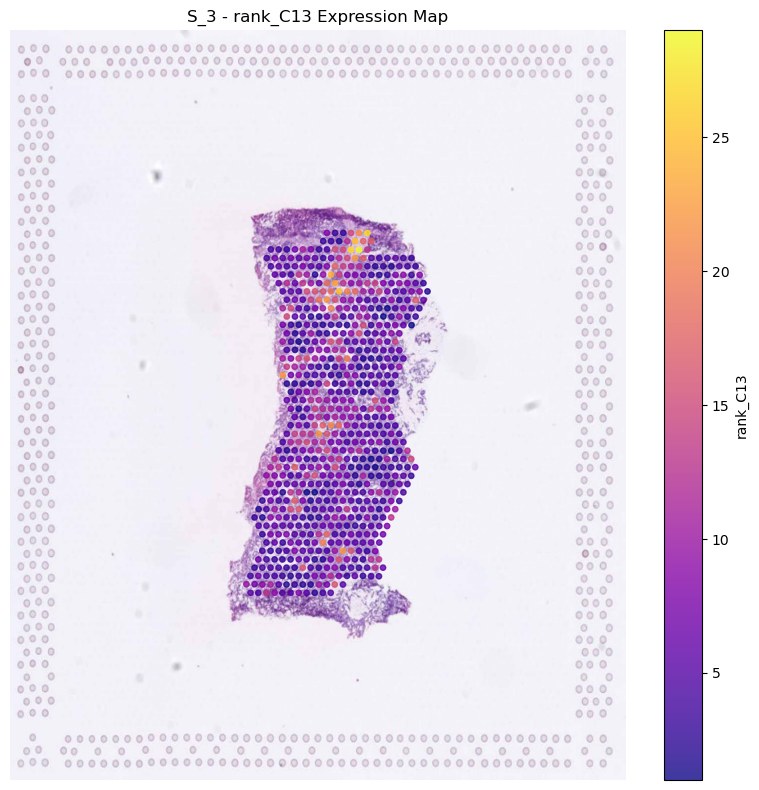

In [92]:
from python_scripts.expression_plot_utils import plot_cell_expression_on_slide
plot_cell_expression_on_slide(
    slide_id = "S_3",
    cell_type = "C13",
    cell_prefix="rank_",  # or zscore_boxcox_filtered_
    image_path="./dataset/elucidata_ai_challenge_data.h5",
    spot_path="dataset/spot-rank/version-2/gu_rank_radius_30.h5",
    group_name="Train"
)